In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
from sklearn import linear_model 
from sklearn import ensemble
from sklearn import model_selection
from itertools import chain

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn import feature_selection
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import ElasticNetCV


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

import sklearn.metrics as metrics

import pickle


import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
matplotlib.style.use('ggplot')

# игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

### 1. Загрузка данных

In [2]:
# загружаем данные
data = pd.read_csv('data_diplom.csv')
# работать будем с копией
df = data.copy()
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


*Наш целевой признак - target, цена объекта*

In [3]:
# посмотрим на столбцы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

*Все столбцы имеют тип object, во многих их них есть пропуски.*

Описание данных:  

➔ 'status' — статус продажи;  
➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;  
➔ 'propertyType' — тип объекта недвижимости;  
➔ 'street' — адрес объекта;  
➔ 'baths' — количество ванных комнат;  
➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);  
➔ 'fireplace' — наличие камина;  
➔ 'city' — город;  
➔ 'schools' — сведения о школах в районе;  
➔ 'sqft' — площадь в футах;  
➔ 'zipcode' — почтовый индекс;  
➔ 'beds' — количество спален;  
➔ 'state' — штат;  
➔ 'stories' — количество этажей;  
➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);  
➔ 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

### 2. Очистка данных

Проверим количество дубликатов:

In [4]:
df.duplicated().sum()

50

Удалим все дубликаты:

In [5]:
df = df.drop_duplicates(ignore_index=True)
df.duplicated().sum()

0

Посмотрим на пропуски:

In [6]:
df.isnull().sum()

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274023
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150673
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

Пропусков много, выведем процентное соотношение:

In [7]:
miss_percent = df.isnull().mean() * 100
miss_percent.sort_values(ascending=False)

private pool    98.891378
mls-id          93.386453
PrivatePool     89.311520
fireplace       72.659127
stories         39.952007
baths           28.188315
beds            24.196640
MlsId           17.730786
sqft            10.752118
status          10.584274
propertyType     9.209699
target           0.657589
city             0.009015
street           0.000530
zipcode          0.000000
schools          0.000000
state            0.000000
homeFacts        0.000000
dtype: float64

*В четырех признаках нет пропусков, а в трех - более 70% пропусков.*

Посмотрим на каждый из признаков


2.1 `mls-id` и `MlsId` 

Поскольку MlsId и mls-id - это код в централизованной системе учёта предложений объектов недвижимости, то на цену объекта он ни как не влияет, и эти признаки можно удалить.

In [8]:
df = df.drop(['mls-id', 'MlsId'], axis=1)

#### 2.2 `private pool` и `PrivatePool`

Оба эти признака содержат информацию о наличии бассейна и в обоих очень много пропусков. Посмотрим на содержимое принзнаков: 

In [9]:
print("Признак 'private pool' соддержит следующие уникальные значения: ", df['private pool'].unique())
print("Признак 'PrivatePool' соддержит следующие уникальные значения: ", df['PrivatePool'].unique())

Признак 'private pool' соддержит следующие уникальные значения:  [nan 'Yes']
Признак 'PrivatePool' соддержит следующие уникальные значения:  [nan 'yes' 'Yes']


In [10]:
# Заменим 'yes' на 'Yes' в признаке `PrivatePool`:
df['PrivatePool'] = df['PrivatePool'].replace('yes', 'Yes')

In [50]:
# посмотрим сколько расхождений
df['PrivatePool'].isin(df['private pool']).value_counts()

True    377135
Name: PrivatePool, dtype: int64

In [11]:
# выведем только различающиеся
mask_pool = np.invert(df['PrivatePool'].isin(df['private pool']))
pool_diff = df[mask_pool][['PrivatePool','private pool']]
pool_diff

,PrivatePool,private pool


Различий нет, значит один столбец можно удалить

In [12]:
# удаляем столбец 'private pool'
df = df.drop('private pool', axis = 1)

Пропуски могут означать отсутствие бассейна либо отсутствие информации о бассейне. Предположу, что наличие бассейна указывается в объявлении, а вот при его отсутствии ничего не указывается. Тогда для нас пропуски означают отсутствие бассейна. Исходя из этой гипотезы, бинарно закодируем признак - '1' будет означать наличие бассейна, а '0' его отсутствие.

In [13]:

# кодируем признак
df['PrivatePool' ] = df['PrivatePool' ].apply( lambda x: 1 if x == 'Yes' else 0)
df['PrivatePool' ].info()


<class 'pandas.core.series.Series'>
RangeIndex: 377135 entries, 0 to 377134
Series name: PrivatePool
Non-Null Count   Dtype
--------------   -----
377135 non-null  int64
dtypes: int64(1)
memory usage: 2.9 MB


#### 2.3 `fireplace` 

Признак содержит информацию о наличии камина. Посмотрим на его содержание:

In [14]:
print("Признак 'fireplace' соддержит следующие уникальные значения: ", df['fireplace'].unique())
print(f"Количество уникальных значений признака 'fireplace': {df['fireplace'].str.lower().nunique()}")


Признак 'fireplace' соддержит следующие уникальные значения:  ['Gas Logs' nan 'yes' ...
 'Ceiling Fan, Fire Sprinkler System, Storage, Utility Connection'
 'Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet'
 'Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets']
Количество уникальных значений признака 'fireplace': 1652


Думаю, что записи и проуски здесь говорят именно об отсутствии информации о камине, а не об  отсутствии самого камина. С учетом количества пропусков, принято решение об удалении признака.

In [15]:
df = df.drop('fireplace', axis=1)

#### 2.4 `propertyType` 

В этом признаке указан тип объекта недвижимости. Посмотрим на его содержимое:

In [16]:
print(f"Количество уникальных значений признака 'propertyType': {df['propertyType'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'propertyType': {df['propertyType'].isnull().sum()}")
print(f"Распределение значений признака 'propertyType' в %: \n{df['propertyType'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'propertyType': 1272
Количество пропусков в признаке 'propertyType': 34733
Распределение значений признака 'propertyType' в %: 
single-family home                                             26.927121
single family                                                  18.360582
condo                                                          12.419612
single family home                                              9.266301
lot/land                                                        5.994708
                                                                 ...    
custom, elevated, other                                         0.000292
contemporary, farmhouse                                         0.000292
2 stories, traditional, mediterranean, texas hill country       0.000292
1 story, contemporary, traditional, mediterranean               0.000292
bilevel, converted dwelling, loft with bedrooms, condo/unit     0.000292
Name: propertyType, Length: 1

Сгруппируем значения признака:

In [17]:
# приведем к строчному виду
df['propertyType'] = df['propertyType'].str.lower()

# отбросим ненужную информацию, находящуюся после запятой
df['propertyType'] = df['propertyType'].str.split(',').str[0]

# создадим словарь, с помощью которого будем группировать значения признака
propertyType_group_dict = {
    'single-family home': [
        'single-family home', 'single family home', '1 story','one story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 
        'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land', 'two story', 'one story', 'one level unit',
        'rancher', '1 1/2 story', 'single wide mh', 'one story traditional'],
    'multi-family home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family'],
    'condominium': [
        'condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse', 
        'co-op', '2 story condo', '2 unit condo', 'condominium (single level)', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile home': [
        'mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 
        'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch'],
    'modern': [
        'contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': [
        'historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic']    
}

# напишем функцию, которая на вход получает значение признака, 
# а возвращает название группы из словаря. Если значения в словаре нет, возвращает 'other'
def group_property_type(propertyType):
    for key, value in propertyType_group_dict.items():
        if propertyType in value:
            return key
    return 'other'

# группируем значения признака
df['propertyType']= df['propertyType'].apply(group_property_type)

Посмотрим распределение значений после группировки:

In [18]:
df['propertyType'].value_counts(normalize=True) * 100

single-family home    35.284447
other                 30.348019
condominium           15.169899
land                   8.341840
townhouse              4.916807
multi-family home      3.273629
mobile home            0.941573
modern                 0.862291
ranch                  0.539064
apartment              0.280006
miscellaneous          0.025455
historical             0.016970
Name: propertyType, dtype: float64

#### 2.5 `street` 

В этом признаке содержится информация об адресе объекта. Посмотрим на него:

In [19]:
print(f"Количество уникальных значений признака 'street': {df['street'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'street': {df['street'].isnull().sum()}")
print(f"Распределение значений признака 'street' в %: \n{df['street'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'street': 336266
Количество пропусков в признаке 'street': 2
Распределение значений признака 'street' в %: 
address not disclosed    0.178186
undisclosed address      0.137087
(undisclosed address)    0.103677
address not available    0.046403
unknown address          0.019091
                           ...   
1003 w oxford st         0.000265
6 loney cir              0.000265
4040 nw 19th st #101     0.000265
4425 roth dr             0.000265
5983 midcrown dr         0.000265
Name: street, Length: 336266, dtype: float64


Самые популярные значения - "Адрес не разглашается", "Адрес недостуен", "Адрес неизвестен". Но в процентном выражении их количество незначительно - менее 1%. Остальные записи - конкретные адреса, которые не представляется возможным сгруппировать. Удалим этот признак.

In [20]:
df = df.drop('street', axis=1)

#### 2.6 `baths` 

Признак содержит информацию о количестве ванных комнат. Посмотрим на его содержимое:

In [21]:
print(f"Количество уникальных значений признака 'baths': {df['baths'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'baths': {df['baths'].isnull().sum()}")
print(f"Распределение значений признака 'baths' в %: \n{df['baths'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'baths': 227
Количество пропусков в признаке 'baths': 106308
Распределение значений признака 'baths' в %: 
2 baths          19.371407
3 baths          13.109845
2                 7.551684
2.0               6.120143
4 baths           5.451081
                   ...    
29 baths          0.000369
bathrooms: 21     0.000369
35                0.000369
bathrooms: 27     0.000369
44.0              0.000369
Name: baths, Length: 227, dtype: float64


In [22]:
# посмотрим на значения ghbpyfrf
df['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '0', '5.0', '1,500', '7.0',
       '1,250', '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500',
       '1.5 Baths', '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+',
       '6', '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ',
       '5 ba', '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0',
       '1.1 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 B

In [23]:
# Для начала удалим буквы, двоеточия и пробелы, оставив только числа и заменим ',' на '.'
df['baths'] = df['baths'].str.replace('[a-zA-Z+:]','', regex=True) \
.str.replace(':','', regex=True) \
.str.replace(' ','', regex=True) \
.str.replace(',','.', regex=True)

df['baths'].unique()

array(['3.5', '3', '2', '8', nan, '1.750', '4', '5', '1.000', '7', '2.0',
       '3.0', '1', '4.0', '2.1', '2.5', '4.5', '6', '2.500', '5.5', '1.0',
       '1.5', '~', '4.000', '2.000', '3.000', '8.0', '0', '5.0', '1.500',
       '7.0', '1.250', '9', '2.250', '6.0', '12', '3.500', '2.750', '750',
       '10', '19', '10.0', '7.5', '0/0', '..', '18', '--', '11', '5.000',
       '1.75', '12.0', '1.1', '6.5', '16', '13', '14', '9.0', '8.5', '17',
       '241', '16.0', '10.5', '7.500', '11.0', '20', '40', '1-0/1-0/1',
       '14.0', '2.75', '24', '22.0', '0.00', '2.25', '3.1', '3.25', '—',
       '22', '32', '18.0', '0.0', '27', '26', '20.0', '9.5', '15', '35',
       '3.75', '29', '116/116/116', '21', '5.2', '14.5', '76', '13.0', '',
       '3-1/2-2', '15.0', '23', '3.3', '43', '1.25', '34', '2.2',
       '1/1/1/1', '55.0', '25', '12.5', '44', '0.5', '4.25', '4.75',
       '0.75', '4.1', '5.25', '41.0', '1.8', '36', '30', '24.0', '23.0',
       '28', '2.8', '34.0', '64.0', '11.5', '39', '3

В США нецелые обозначения ванных комнат (1.5, 1.75, 2.5) могут означать, что в части из них отсутствует ванна. Вместо нее может быть душевая кабина или ванна вообще отсутствует, только раковина и унитаз. То есть, такие значения можно оставить. Что означает символ "+" сложно сказать, просто удалим его. Значения через "/" могут означать количество ванных комнат по этажам, либо по квартирам. Посмотрим на такие дома:

In [24]:
df[df['baths'] == '1-0/1-0/1']

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
24724,Active,multi-family home,1-0/1-0/1,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Nashville,"[{'rating': ['6', '5', '3', '4', '5', 'NR', 'N...",2932,37212,3.0,TN,2.00,0,"$775,000"


In [25]:
df[df['baths'] == '116/116/116']

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
63510,Active,multi-family home,116/116/116,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Madison,"[{'rating': ['1', 'NR', '3', '1', '2', '1', 'N...",99999,37115,NaN,TN,2.00,0,"$1,600,000"


In [26]:
df[df['baths'] == '3-1/2-2']

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
85354,Active,multi-family home,3-1/2-2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Nashville,"[{'rating': ['2', '4', '3', '3', '2', 'NR', 'N...",1939,37209,3.0,TN,3.00,0,"$5,750,000"


In [27]:
df[df['baths'] == '1/1/1/1']

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
110090,Active,multi-family home,1/1/1/1,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",Nashville,"[{'rating': ['2', '3', '2', '1', '2', '2', 'NR...",4408,37211,3.0,TN,1.00,0,"$985,000"


In [28]:
df[df['baths'] == '2-1/2-1/1-1/1-1']

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
301145,Active,multi-family home,2-1/2-1/1-1/1-1,"{'atAGlanceFacts': [{'factValue': '1900', 'fac...",Nashville,"[{'rating': ['1', '2', '3', '1', '4', '10', 'N...",11740,37201,2.0,TN,5.00,0,"$7,450,000"


In [29]:
df[df['baths'] == '1/1-0/1-0/1-0']

,status,propertyType,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
316452,Active,multi-family home,1/1-0/1-0/1-0,"{'atAGlanceFacts': [{'factValue': '1966', 'fac...",Madison,"[{'rating': ['3', '2', '3', '1', '2', '1', 'NR...",1324,37115,2.0,TN,1.00,0,"$2,250,000"


Все дома с таким обозначением ванных комнат являются "multy-family", поэтому принимаем версию, что таким образом указано количество ванных комнат для каждой семьи. У объекта с ID 63510 указано "116/116/116" ванных комнат и площадь 99999 квадратных футов - видимо это ошибка при внесении данных, удалим его. Для остальных просуммируем ванные комнаты. Также заменим некоторые значения на "0":

In [30]:
df['baths'].replace(['1-2'], '2', inplace=True)
df['baths'].replace(['1-0/1-0/1', '3-1/2-2'], '3', inplace=True)
df['baths'].replace(['1/1/1/1', '2-1/2-1/1-1/1-1', '1/1-0/1-0/1-0'], '4', inplace=True)
df['baths'].replace(['~','0/0','..','--','—',''],0,inplace=True)
# удалим объект с ID 63510
df['baths'] = df['baths'].drop([63510])
# заменим NaN на 0
df['baths'] = df['baths'].fillna(0)
# пореобразуем в тип float
df['baths'] = df['baths'].astype(float)
# смотрим что получилось
df['baths'].unique()

array([3.50e+00, 3.00e+00, 2.00e+00, 8.00e+00, 0.00e+00, 1.75e+00,
       4.00e+00, 5.00e+00, 1.00e+00, 7.00e+00, 2.10e+00, 2.50e+00,
       4.50e+00, 6.00e+00, 5.50e+00, 1.50e+00, 1.25e+00, 9.00e+00,
       2.25e+00, 1.20e+01, 2.75e+00, 7.50e+02, 1.00e+01, 1.90e+01,
       7.50e+00, 1.80e+01, 1.10e+01, 1.10e+00, 6.50e+00, 1.60e+01,
       1.30e+01, 1.40e+01, 8.50e+00, 1.70e+01, 2.41e+02, 1.05e+01,
       2.00e+01, 4.00e+01, 2.40e+01, 2.20e+01, 3.10e+00, 3.25e+00,
       3.20e+01, 2.70e+01, 2.60e+01, 9.50e+00, 1.50e+01, 3.50e+01,
       3.75e+00, 2.90e+01, 2.10e+01, 5.20e+00, 1.45e+01, 7.60e+01,
       2.30e+01, 3.30e+00, 4.30e+01, 3.40e+01, 2.20e+00, 5.50e+01,
       2.50e+01, 1.25e+01, 4.40e+01, 5.00e-01, 4.25e+00, 4.75e+00,
       7.50e-01, 4.10e+00, 5.25e+00, 4.10e+01, 1.80e+00, 3.60e+01,
       3.00e+01, 2.80e+01, 2.80e+00, 6.40e+01, 1.15e+01, 3.90e+01,
       4.20e+01, 3.20e+00, 6.00e+01, 6.75e+00, 6.80e+01])

#### 2.7 `homeFacts` 

Признак содержит сведения о строительстве объекта. Пропуски отсутствуют. Посмотрим на его содержимое:

In [31]:
print(f"Количество уникальных значений признака 'homeFacts': ", df['homeFacts'].nunique())
df['homeFacts'][0]

Количество уникальных значений признака 'homeFacts':  321009


"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Признак представляет из себя словарь, содержащий 2 группы фактов 'factValue' и 'factLabel' (значение факта и название факта).
Посмотрим на названия:

In [32]:
label = df['homeFacts'].str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")

#создадим список названий фактов
list_label = ','.join(label[0]).replace("'","").split(',')
list_label

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

Видим, что факты очень полезны для нас. Выделим их в отдельные признаки для нашего датасета. Для этого создадим список значений фактов для каждого объекта, как мы это сделали для названий:

In [33]:
#создадим список значений фактов
value = df['homeFacts'].str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")

# Создадим эти признаки в нашем фрейме и заполним значениями
for i, val in enumerate(list_label):
    df[val]=value.apply(lambda x: x[i])
    
#Признак homeFacts больше не нужен, удалим его  
df = df.drop('homeFacts', axis=1)

df.head(3)

,status,propertyType,baths,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,Active,single-family home,3.5,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,0,"$418,000",'2019','',"'Central A/C, Heat Pump'",'','',None,'$144'
1,for sale,single-family home,3.0,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,0,"$310,000",'2019','','','','','5828 sqft','$159/sqft'
2,for sale,single-family home,2.0,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,1,"$2,895,000",'1961','1967','Forced Air','Central','Attached Garage',"'8,626 sqft'",'$965/sqft'


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377135 entries, 0 to 377134
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337218 non-null  object 
 1   propertyType    377135 non-null  object 
 2   baths           377135 non-null  float64
 3   city            377101 non-null  object 
 4   schools         377135 non-null  object 
 5   sqft            336585 non-null  object 
 6   zipcode         377135 non-null  object 
 7   beds            285881 non-null  object 
 8   state           377135 non-null  object 
 9   stories         226462 non-null  object 
 10  PrivatePool     377135 non-null  int64  
 11  target          374655 non-null  object 
 12  Year built      377135 non-null  object 
 13  Remodeled year  377135 non-null  object 
 14  Heating         377135 non-null  object 
 15  Cooling         377135 non-null  object 
 16  Parking         377135 non-null  object 
 17  lotsize   

Пропусков в новых признаках нет. Посмотрим на них поближе:

#### 2.8 `Year built`

Год постройки здания. Посмотрим на содержимое:

In [35]:
print(f"Количество уникальных значений признака 'Year built': {df['Year built'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'Year built': {df['Year built'].isnull().sum()}")
print(f"Распределение значений признака 'Year built' в %: \n{df['Year built'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'Year built': 231
Количество пропусков в признаке 'Year built': 0
Распределение значений признака 'Year built' в %: 
''        15.572408
'2019'     8.529572
'2006'     2.123378
'2005'     1.989473
'2007'     1.896138
            ...    
'1823'     0.000265
'1740'     0.000265
'1700'     0.000265
'1807'     0.000265
'1804'     0.000265
Name: Year built, Length: 231, dtype: float64


In [36]:
# убираем кавычки
df['Year built'] = df['Year built'].str.replace("'",'', regex=True)

# посмотрм на содержимое
l = list(df['Year built'].unique())
l.sort()
print(l)

['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790', '1794', '1795', '1796', '1799', '1800', '1802', '1803', '1804', '1805', '1807', '1808', '1809', '1810', '1811', '1812', '1815', '1816', '1817', '1818', '1820', '1822', '1823', '1824', '1825', '1828', '1829', '1830', '1831', '1832', '1834', '1835', '1836', '1840', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921'

Есть несколько странных дат. Скорее всего, это ошибки при заполнении. Их довольно мало, посмотрим на количество объектов с такими датами:

In [37]:
df[(df['Year built'] == '1') | (df['Year built'] == '1019') | (df['Year built'] == '1057') | \
    (df['Year built'] == '1060') | (df['Year built'] == '1208') | (df['Year built'] == '2025') | (df['Year built'] == '559990649990')].shape[0]

10

Их всего 10, избавимся от них:

In [38]:
strange_years = ['1', '1019', '1057', '1060', '1208', '2025', '559990649990']
df = df[df['Year built'].isin(strange_years) == False]

Также посмотрим на количество объектов без указания даты постройки:

In [39]:
df[(df['Year built'] == '') | (df['Year built'] == 'No Data') | (df['Year built'] == 'None')].shape[0]

63564

Их слишком много, чтобы можно было просто удалить их, поэтому всем им присвоим значение 'no data'

In [40]:
df['Year built'] = df['Year built'].replace(['', 'No Data', 'None'],'no data', regex=True)

# посмотрим что получилось
l = list(df['Year built'].unique())
l.sort()
print(l)

['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790', '1794', '1795', '1796', '1799', '1800', '1802', '1803', '1804', '1805', '1807', '1808', '1809', '1810', '1811', '1812', '1815', '1816', '1817', '1818', '1820', '1822', '1823', '1824', '1825', '1828', '1829', '1830', '1831', '1832', '1834', '1835', '1836', '1840', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926',

#### 2.9 `Remodeled year`

Год реконструкции объекта. Посмотрим на содержимое признака:

In [41]:
print(f"Количество уникальных значений признака 'Remodeled year': {df['Remodeled year'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'Remodeled year': {df['Remodeled year'].isnull().sum()}")
print(f"Распределение значений признака 'Remodeled year' в %: \n{df['Remodeled year'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'Remodeled year': 154
Количество пропусков в признаке 'Remodeled year': 0
Распределение значений признака 'Remodeled year' в %: 
''        52.896785
none       7.044614
'2006'     1.468479
'2005'     1.277295
'2007'     1.163275
            ...    
'1853'     0.000265
'1888'     0.000265
'1800'     0.000265
'1738'     0.000265
'1862'     0.000265
Name: Remodeled year, Length: 154, dtype: float64


In [42]:
# убираем кавычки
df['Remodeled year'] = df['Remodeled year'].str.replace("'",'', regex=True)

# посмотрм на содержимое
l = list(df['Remodeled year'].unique())
l.sort()
print(l)

['', '0', '1738', '1800', '1845', '1846', '1853', '1862', '1869', '1870', '1874', '1876', '1877', '1880', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994'

Проведем небольшие преобразования:

In [43]:
df['Remodeled year'] = df['Remodeled year'].replace(['', 'None'],'no data', regex=True)

# посмотрм что получилось
l = list(df['Remodeled year'].unique())
l.sort()
print(l)

['0', '1738', '1800', '1845', '1846', '1853', '1862', '1869', '1870', '1874', '1876', '1877', '1880', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1

Проверим, есть ли дома, у которых реконструкция была проведена раньше постройки:

In [44]:
no_none_df = df[(df['Remodeled year'] != 'no data') & (df['Year built'] != 'no data')]
no_none_df[no_none_df['Remodeled year'] < no_none_df['Year built']].shape[0]


3650

Таких домов довольно много, разбиратся с каждым займет слишком много времени. Принято решение об удалении признака.

In [45]:
df = df.drop('Remodeled year', axis=1)

#### 2.10 `Heating`

Признак указывает на наличие отопления. Посмотрим на его содержимое:

In [46]:
print(f"Количество уникальных значений признака 'Heating': {df['Heating'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'Heating': {df['Heating'].isnull().sum()}")
print(f"Распределение значений признака 'Heating' в %: \n{df['Heating'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'Heating': 1919
Количество пропусков в признаке 'Heating': 0
Распределение значений признака 'Heating' в %: 
'forced air'                                                      35.613656
''                                                                28.041631
'other'                                                            7.854690
'electric'                                                         2.708916
'gas'                                                              2.464965
                                                                    ...    
'zoned heating, wall unit heating, forced air heating'             0.000265
'baseboard, spacewallunit'                                         0.000265
'hot air, stove-pellet'                                            0.000265
'natural gas, space heater'                                        0.000265
'baseboard, hot water, programmable thermostat, radiant floor'     0.000265
Name: Heating, 

Закодируем признак бинарно. "1" будет означать наличие отопления, "0" - его отсутствие: 

In [47]:
df['Heating'] = df['Heating'].apply(lambda x: 1 if x not in ["''", "'no data'", "'None'", "'none'"] else 0)
df['Heating'].value_counts()

1    271301
0    105824
Name: Heating, dtype: int64

#### 2.11 `Cooling`

Признак указывает на наличие системы охлаждения. Посмотрим на его содержимое:

In [48]:
print(f"Количество уникальных значений признака 'Cooling': {df['Cooling'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'Cooling': {df['Cooling'].isnull().sum()}")
print(f"Распределение значений признака 'Cooling' в %: \n{df['Cooling'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'Cooling': 1439
Количество пропусков в признаке 'Cooling': 0
Распределение значений признака 'Cooling' в %: 
'central'                                                                42.093205
''                                                                       31.922572
'central air'                                                             3.814120
'no data'                                                                 2.814717
'has cooling'                                                             2.580046
                                                                           ...    
'central gas, propane, zoned'                                             0.000265
'other (see remarks), panel/floor/wall, window unit'                      0.000265
'multi units, zoned cooling'                                              0.000265
'central air, g-energy star hvac, gas hot air/furnace, multizone a/c'     0.000265
'central a/c (gas), c

Также закодируем признак бинарно. "1" будет означать наличие системы охлаждения, "0" - его отсутствие: 

In [49]:
df['Cooling'] = df['Cooling'].apply(lambda x: 1 if x not in ["''", "'no data'", "'None'", "'none'"] else 0)
df['Cooling'].value_counts()

1    249347
0    127778
Name: Cooling, dtype: int64

#### 2.12 `Parking`

Признак указывает на наличие парковки. Посмотрим на его содержимое:

In [50]:
print(f"Количество уникальных значений признака 'Parking': {df['Parking'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'Parking': {df['Parking'].isnull().sum()}")
print(f"Распределение значений признака 'Parking' в %: \n{df['Parking'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'Parking': 3321
Количество пропусков в признаке 'Parking': 0
Распределение значений признака 'Parking' в %: 
''                                                                                                                                    45.564998
'attached garage'                                                                                                                     18.759828
'2 spaces'                                                                                                                             7.440769
'1 space'                                                                                                                              3.779118
'no data'                                                                                                                              3.535433
                                                                                                                                   

Этот признак также бинарно. "1" будет означать наличие парковки, "0" - его отсутствие: 

In [51]:
df['Parking'] = df['Parking'].apply(lambda x: 1 if x not in ["''", "'no data'", "'None'", "'none'", "'0'"] else 0)
df['Parking'].value_counts()

1    201806
0    175319
Name: Parking, dtype: int64

#### 2.13 `lotsize`

Признак указывает на размер продаваемого лота. Посмотрим на него:

In [52]:
print(f"Количество уникальных значений признака 'lotsize': {df['lotsize'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'lotsize': {df['lotsize'].isnull().sum()}")
print(f"Распределение значений признака 'lotsize' в %: \n{df['lotsize'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'lotsize': 36607
Количество пропусков в признаке 'lotsize': 0
Распределение значений признака 'lotsize' в %: 
''                  8.764998
none                7.526417
'—'                 6.695128
'no data'           1.413059
'-- sqft lot'       1.012662
                      ...   
'6956'              0.000265
'13274'             0.000265
'45128'             0.000265
'17404'             0.000265
'7,084 sqft lot'    0.000265
Name: lotsize, Length: 36607, dtype: float64


Значения '', 'none', '-', 'no data' по сути являются пропусками и количество этих пропусков довольно большое. удаляем этот признак:

In [53]:
df = df.drop('lotsize', axis=1)

#### 2.14 `Price/sqft`

Признак показывает отношение цены объекта к его площади. Во избежания утечки данных удалим его:

In [54]:
df= df.drop('Price/sqft', axis=1)

#### 2.15 `city` 

Признак содержит информацию о городе. Посмотрим на его содержимое:

In [55]:
print(f"Количество уникальных значений признака 'city': {df['city'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'city': {df['city'].isnull().sum()}")
print(f"Распределение значений признака 'city' в %: \n{df['city'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'city': 1909
Количество пропусков в признаке 'city': 34
Распределение значений признака 'city' в %: 
houston         6.481459
san antonio     4.134811
miami           4.117839
jacksonville    2.660366
dallas          2.348770
                  ...   
santa fe        0.000265
encinal         0.000265
magna           0.000265
whallonsburg    0.000265
blue springs    0.000265
Name: city, Length: 1909, dtype: float64


В признаке 34 пропуска, посмотрим на них:

In [56]:
df[df['city'].isnull()]

,status,propertyType,baths,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target,Year built,Heating,Cooling,Parking
7830,Active,single-family home,2.0,NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,2,0,"$1,495,000",2000,1,1,1
21529,Active,land,0.0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32668,NaN,FL,NaN,0,"$49,900",no data,0,0,0
26466,Active,land,0.0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,0,"$417,718",no data,0,0,0
60990,Active,land,0.0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,0,"$31,334",no data,0,0,0
81509,Active,land,0.0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34432,NaN,FL,NaN,0,"$28,000",no data,0,0,0
122337,Active,land,0.0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34481,NaN,FL,NaN,0,"$18,000",no data,0,0,0
123481,Active,land,0.0,NaN,"[{'rating': ['6', '5', '7', '7', '2', '10', 'N...",0,33955,NaN,FL,NaN,0,"$4,000",no data,0,0,0
130554,For sale,other,6.0,NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,NaN,0,"$1,650,000",2000,1,0,1
131266,Active,land,0.0,NaN,"[{'rating': ['5', '4', '6', 'NR', '5', 'NR', '...",0,33954,NaN,FL,NaN,0,"$4,200",no data,0,0,0
151954,Active,land,0.0,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,0,"$31,334",no data,0,0,0


In [57]:
# Возьмем названия городов с сайта https://zipcodes.org/ и заполним пропуски
df.at[7830,'city'] = 'Reddick'
df.at[21529,'city'] = 'Morriston'
df.at[26466,'city'] = 'Laredo'
df.at[60990,'city'] = 'Ocala'
df.at[81509,'city'] = 'Dunnellon'
df.at[122337,'city'] = 'Ocala'
df.at[123481,'city'] = 'Punta Gorda'
df.at[123481,'city'] = 'Punta Gorda'
df.at[130554,'city'] = 'Washington'
df.at[151954,'city'] = 'Ocala'
df.at[170335,'city'] = 'Kissimmee'
df.at[171290,'city'] = 'Laredo'
df.at[186779,'city'] = 'Ocala'
df.at[199648,'city'] = 'Ocala'
df.at[215069,'city'] = 'Silver Springs'
df.at[221264,'city'] = 'Laredo'
df.at[221853,'city'] = 'Laredo'
df.at[222785,'city'] = 'Ocala'
df.at[262327,'city'] = 'Cleveland'
df.at[270897,'city'] = 'Laredo'
df.at[277436,'city'] = 'Reddick'
df.at[278490,'city'] = 'Kissimmee'
df.at[281993,'city'] = 'Kissimmee'
df.at[304900,'city'] = 'Kissimmee'
df.at[309230,'city'] = 'Kissimmee'
df.at[312934,'city'] = 'Dunnellon'
df.at[325746,'city'] = 'Punta Gorda'
df.at[331144,'city'] = 'Ocklawaha'
df.at[342308,'city'] = 'Laredo'
df.at[346252,'city'] = 'Miami'
df.at[355353,'city'] = 'Punta Gorda'
df.at[358892,'city'] = 'Kissimmee'
df.at[370033,'city'] = 'Houston'
df.at[370460,'city'] = 'Ocklawaha'

#### 2.16 `schools` 

В данном признаке находятся сведения о школах в районе. Посмотрим на его содержимое:

In [58]:
print(f"Количество уникальных значений признака 'schools': {df['schools'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'schools': {df['schools'].isnull().sum()}")
print(f"Распределение значений признака 'schools' в %: \n{df['schools'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'schools': 297359
Количество пропусков в признаке 'schools': 0
Распределение значений признака 'schools' в %: 
[{'rating': [], 'data': {'distance': [], 'grades': []}, 'name': []}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1.114485
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'distance': ['39.69mi', '39.69mi', '39.69mi'], 'grades': ['9-12', '6-8', 'pk-5']}, 'name': ['fort hancock high school', 'fort hancock middle school', 'benito martinez elementary school']}]                                                                                     

Признак представлен в виде словаря, в котором содержатся сведения о рейтинге школы, расстоянии до нее, оценках и наименовании. Наименование и оценки для нас не являются информативными признаками, в отличие от рейтинга школы и расстояния до нее. Сформируем 2 новых признака: school_rating_mean - средний рейтинг школы, school_dist_min - минимальное растояние до школы

In [59]:
# функция для рассчета среднего рейтинга
def mean_rating(rating):
    rating = rating[0].replace('/10', '') # убираем лишние символы
    extracted_numbers = [float(num) for num in rating if num.isdigit()] # приводим к float
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1 # вычисляем среднее, пропуски заполним "-1"
    return round(average_rating, 1)

s_rating = (df['schools'].str.findall(r"\brating': ([\s\S]+?), 'data\b").apply(lambda x: mean_rating(x)))

# создаем признак school_rating_mean в нашем наборе данных. 
df['school_rating_mean'] = s_rating

# ищем расстояние до школы 
s_distance = df.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b") 
# берем первое значения из полученных
s_distance = s_distance.apply(lambda x: x[0]) 
# удаляем все буквы
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True) 
# ищем числа
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)') 
# приводим к float
s_distance = s_distance.apply(lambda x: [float(i) for i in x]) 
# находим минимальное значение в каждом списке s_distance, и возвращение -1, если длина списка равна 0
school_dist_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x)) 

# создаем признак school_dist_min в нашем наборе данных.
df['school_dist_min'] = school_dist_min

# удалим признак schools:
df = df.drop('schools', axis=1)

#### 2.17 `sqft` 

Площадь здания в футах.

In [60]:
print(f"Количество уникальных значений признака 'sqft': {df['sqft'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'sqft': {df['sqft'].isnull().sum()}")
print(f"Распределение значений признака 'sqft' в %: \n{df['sqft'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'sqft': 25405
Количество пропусков в признаке 'sqft': 40550
Распределение значений признака 'sqft' в %: 
0                                          3.521949
1,200 sqft                                 0.249276
1,000 sqft                                 0.194310
1,100 sqft                                 0.170244
1,800 sqft                                 0.167273
                                             ...   
total interior livable area: 3,055 sqft    0.000297
5,177                                      0.000297
11620                                      0.000297
46,118 sqft                                0.000297
total interior livable area: 4,615 sqft    0.000297
Name: sqft, Length: 25405, dtype: float64


Преобразуем признак в int:

In [61]:
# выбираем все значения не nan
df_sqft = df.sqft[df.sqft.notna()]
# выбираем все числовые значения
df_sqft = df_sqft.str.findall(r"\d+")
# преобразуем 
df_sqft = df_sqft.apply(lambda x: ''.join(x))
# заполняем значения признака sqft получившимися значениями
df.loc[df.sqft.notna(), 'sqft']=df_sqft
# меняем пропуски на 0
df['sqft'] = df['sqft'].fillna(0)
# меняем пустые строки на 0
df.loc[df.sqft=='','sqft'] = 0
# приобразуем в int
df.sqft = df.sqft.astype(int)
print(f"Количество уникальных значений:{df['sqft'].nunique()}")
print(f"количество пропусков:{df['sqft'].isna().sum()}")
print(f"распределение значений:\n{df['sqft'].value_counts()}")

Количество уникальных значений:9897
количество пропусков:0
распределение значений:
0          53224
1200        1426
1000        1027
1500        1014
1800         988
           ...  
5728968        1
12503          1
8815           1
15391          1
13870          1
Name: sqft, Length: 9897, dtype: int64


Посмотрим на распределение нулей по типам объектов:

In [62]:
selected_sfh = df[(df['sqft'] == 0) & (df['propertyType'] == 'single-family home')]
percent_sfh = len(selected_sfh)/len(df)*100
single_family_home = df[(df['propertyType'] == 'single-family home')]
percent_single_family_home = len(selected_sfh)/len(single_family_home)*100

selected_multi_family_home = df[(df['sqft'] == 0) & (df['propertyType'] == 'multi-family home')]
multi_family_home = df[(df['propertyType'] == 'multi-family home')]
percent_multi_family_home = len(selected_multi_family_home)/len(multi_family_home)*100

selected_condominium = df[(df['sqft'] == 0) & (df['propertyType'] == 'condominium')]
condominium = df[(df['propertyType'] == 'condominium')]
percent_condo = len(selected_condominium)/len(condominium)*100

selected_townhouse = df[(df['sqft'] == 0) & (df['propertyType'] == 'townhouse')]
townhouse = df[(df['propertyType'] == 'townhouse')]
percent_townhouse = len(selected_townhouse)/len(townhouse)*100

selected_apartment = df[(df['sqft'] == 0) & (df['propertyType'] == 'apartment')]
apartment = df[(df['propertyType'] == 'apartment')]
percent_apartment = len(selected_apartment)/len(apartment)*100

selected_land = df[(df['sqft'] == 0) & (df['propertyType'] == 'land')]
land = df[(df['propertyType'] == 'land')]
percent_land = len(selected_land)/len(land)*100

selected_mobile_home = df[(df['sqft'] == 0) & (df['propertyType'] == 'mobile_home')]
mobile_home = df[(df['propertyType'] == 'mobile home')]
percent_mobile_home = len(selected_mobile_home)/len(mobile_home)*100

selected_miscellaneous = df[(df['sqft'] == 0) & (df['propertyType'] == 'miscellaneous')]
miscellaneous = df[(df['propertyType'] == 'miscellaneous')]
percent_miscellaneous = len(selected_miscellaneous)/len(miscellaneous)*100

selected_ranch = df[(df['sqft'] == 0) & (df['propertyType'] == 'ranch')]
ranch = df[(df['propertyType'] == 'ranch')]
percent_ranch = len(selected_ranch)/len(ranch)*100

selected_modern = df[(df['sqft'] == 0) & (df['propertyType'] == 'modern')]
modern = df[(df['propertyType'] == 'modern')]
percent_modern = len(selected_modern)/len(modern)*100

selected_historical = df[(df['sqft'] == 0) & (df['propertyType'] == 'historical')]
historical = df[(df['propertyType'] == 'historical')]
percent_historical = len(selected_miscellaneous)/len(historical)*100

selected_other = df[(df['sqft'] == 0) & (df['propertyType'] == 'other')]
other = df[(df['propertyType'] == 'other')]
percent_other = len(selected_other)/len(other)*100

type_zero = round((len(df[(df['sqft']==0)])/len(df)*100),2)

d = {'single_family_home':[(round(percent_single_family_home,2))],
     'multi_family_home':[(round(percent_multi_family_home,2))],
     'condo':[(round(percent_condo,2))],
     'townhouse':[(round(percent_townhouse,2))],
     'apartment':[(round(percent_apartment,2))],
     'land':[(round(percent_land,2))],
     'mobile_home':[(round(percent_mobile_home,2))],
     'miscellaneous':[(round(percent_miscellaneous,2))],
     'ranch':[(round(percent_ranch,2))],
     'modern':[(round(percent_modern,2))],
     'historical':[(round(percent_historical,2))],
     'other':[(round(percent_other,2))]}
scope = pd.DataFrame(data=d)
print('% нулевых значений признака sqft по типам объектов')
display(scope)

% нулевых значений признака sqft по типам объектов


,single_family_home,multi_family_home,condo,townhouse,apartment,land,mobile_home,miscellaneous,ranch,modern,historical,other
0,1.33,7.21,3.54,1.9,4.45,86.95,0.0,4.17,2.02,0.98,6.25,17.9


Больше всего нулевых значений у объектов типа 'land' - почти 87%. Неудивительно, ведь при продаже земли площадь здания будет нулевая. У объектов типа 'other' около 18% нулевых значений. Пока оставим все как есть.

#### 2.18 `zipcode` 

Признак содержит информацию о почтовом индексе объекта. Посмотрим на его содержимое:

In [63]:
print(f"Количество уникальных значений признака 'zipcode': {df['zipcode'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'zipcode': {df['zipcode'].isnull().sum()}")
print(f"Распределение значений признака 'zipcode' в %: \n{df['zipcode'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'zipcode': 4549
Количество пропусков в признаке 'zipcode': 0
Распределение значений признака 'zipcode' в %: 
32137         0.567716
33131         0.414451
34747         0.394564
78245         0.368578
34759         0.353464
                ...   
27613-4237    0.000265
43054         0.000265
41630         0.000265
27615-3709    0.000265
64015         0.000265
Name: zipcode, Length: 4549, dtype: float64


Удалим некорректные значения:

In [64]:
df = df.drop(df[(df['zipcode']=='--') | (df['zipcode']=='0')| (df['zipcode']=='00000')].index)
df['zipcode'].nunique()

4546

#### 2.19 `beds` 

Признак показывает количество спален. Посмотрим на его содержимое:

In [65]:
print(f"Количество уникальных значений признака 'beds': {df['beds'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'beds': {df['beds'].isnull().sum()}")
print(f"Распределение значений признака 'beds' в %: \n{df['beds'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'beds': 1183
Количество пропусков в признаке 'beds': 91245
Распределение значений признака 'beds' в %: 
3 beds         18.698448
4 beds         12.387276
3              10.984560
2 beds          9.219097
4               7.006583
                 ...    
8,023 sqft      0.000350
10,193 sqft     0.000350
8.93 acres      0.000350
5,510 sqft      0.000350
8,479 sqft      0.000350
Name: beds, Length: 1183, dtype: float64


Встречаются записи, не соответствующие количеству спален, такие как '...sqft', '...acre', и т.п. Попробуем заменить их на NaN и посмотрим сколько пропусков окажется в принаке:

In [66]:
df['beds'] = df['beds'].apply(lambda x: x if pd.isna(x) else np.nan if x.find('sqft') != -1 else x)
df['beds'] = df['beds'].apply(lambda x: x if pd.isna(x) else np.nan if x.find('acre') != -1 else x)
df['beds'] = df['beds'].apply(lambda x: x if pd.isna(x) else np.nan if x.find('Baths') != -1 else x)
df['beds'] = df['beds'].apply(lambda x: x if pd.isna(x) else np.nan if x.find('Bath') != -1 else x)
df['beds'] = df['beds'].apply(lambda x: x if pd.isna(x) else np.nan if x.find('Based') != -1 else x)
df['beds'] = df['beds'].apply(lambda x: x if pd.isna(x) else np.nan if x.find('--') != -1 else x)
df['beds'] = df['beds'].apply(lambda x: x if pd.isna(x) else np.nan if x.find('# Bedrooms 1st Floor') != -1 else x)

# Проведем небольшие преобразования
df['beds'] = df['beds'].str.replace('[a-zA-Z+:]','', regex=True) \
.str.replace(' ','', regex=True) \
.str.replace(',','.', regex=True) \
.str.replace('3.../.','3', regex=True) \
.str.replace('1-2','2', regex=True) \
.replace('', np.nan, regex=True)


# заменим NaN на 0
df['beds'] = df['beds'].fillna(0)

# приведем к типу float    
df['beds'] = df['beds'].astype(float)
print(f"Количество пропусков в признаке 'beds': ", df['beds'].isnull().sum())
print(f"Количество пропусков в признаке 'beds' в процентах: {df['beds'].isnull().sum() / len(df['beds'])*100}")
print(f"Количество уникальных значений признака 'beds': ", df['beds'].nunique())
print(f"распределение значений:\n{df['beds'].value_counts()[:10]}")

Количество пропусков в признаке 'beds':  0
Количество пропусков в признаке 'beds' в процентах: 0.0
Количество уникальных значений признака 'beds':  54
распределение значений:
0.0     113263
3.0     105822
4.0      68938
2.0      50137
5.0      21699
6.0       6583
1.0       6120
7.0       1825
8.0       1219
9.0        486
10.0       274
Name: beds, dtype: int64


Заменим пропуски медианным значением

In [67]:
df['beds'] = df['beds'].fillna(df['beds'].median())    

#### 2.20 `state` 

Признак описывает штат, в котором находится объект. Посмотрим на его содержимое:

In [68]:
print(f"Количество уникальных значений признака 'state': {df['state'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'state': {df['state'].isnull().sum()}")
print(f"Распределение значений признака 'state' в %: \n{df['state'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'state': 37
Количество пропусков в признаке 'state': 0
Распределение значений признака 'state' в %: 
fl    30.608906
tx    22.215534
ny     6.489198
ca     6.200430
nc     5.794192
tn     4.862656
wa     3.664095
oh     3.337408
il     2.370074
nv     2.249157
ga     1.776893
co     1.698138
pa     1.474601
mi     1.368534
dc     1.239131
az     0.887518
in     0.882215
or     0.739554
ma     0.401995
ut     0.351348
md     0.289033
vt     0.230166
mo     0.229636
va     0.212400
wi     0.119856
nj     0.115613
me     0.068679
ia     0.064171
ky     0.023865
ok     0.012993
ms     0.010607
sc     0.007425
mt     0.001856
de     0.001326
ba     0.000265
al     0.000265
ot     0.000265
Name: state, dtype: float64


Пропусков в признаке нет, оставляем в таком виде.

#### 2.21 `stories` 

Признак содержит информацию о количестве этажей. Посмотрим на его содержимое:

In [69]:
print(f"Количество уникальных значений признака 'stories': {df['stories'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'stories': {df['stories'].isnull().sum()}")
print(f"Распределение значений признака 'stories' в %: \n{df['stories'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'stories': 348
Количество пропусков в признаке 'stories': 150658
Распределение значений признака 'stories' в %: 
1.0                                  29.784819
2.0                                  24.411709
1                                    10.193367
2                                     8.012859
3.0                                   4.977457
                                       ...    
manufactured home, non-site built     0.000442
bedroom - split plan                  0.000442
78                                    0.000442
one, two, multi/split                 0.000442
65.0                                  0.000442
Name: stories, Length: 348, dtype: float64


С одной стороны, количество этажей в доме должно сильно влиять на цену, но с другой в признаке почти 40 % пропусков и многие из 348-ми уникальных значений сложно интерпретировать в конкретное количество этажей. Если попытаться заменить эти "неинтерпретируемые" значения на NaN и заполнить, например, модой или медианным значением этажности, можно сильно исказить реальные данные. Принято решение об удалении этого признака.

In [70]:
df = df.drop('stories', axis=1)

#### 2.22 `status` 

Статус продажи. Посмотрим на содержимое признака:

In [71]:
print(f"Количество уникальных значений признака 'status': {df['status'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'status': {df['status'].isnull().sum()}")
print(f"Распределение значений признака 'status' в %: \n{df['status'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'status': 152
Количество пропусков в признаке 'status': 39916
Распределение значений признака 'status' в %: 
for sale                   59.169402
active                     31.197231
foreclosure                 2.007100
new construction            1.623058
pending                     1.425551
                             ...    
coming soon: oct 29.        0.000297
coming soon: dec 15.        0.000297
pending w/backup wanted     0.000297
pending backups wanted      0.000297
coming soon: dec 23.        0.000297
Name: status, Length: 152, dtype: float64


In [72]:
# Посмотрим на все уникальные значения
print(f"Уникальные значения признака 'status':{list(df['status'].sort_values().unique())}\n")

Уникальные значения признака 'status':[' / auction', 'A Active', 'Accepted Offer', 'Accepting backups', 'Active', 'Active - Auction', 'Active - Contingent', 'Active Backup', 'Active Contingency', 'Active Contingent', 'Active Option', 'Active Option Contract', 'Active Under Contract', 'Active With Contingencies', 'Active With Offer', 'Active with Contract', 'Active/Contingent', 'Apartment for rent', 'Auction', 'Auction - Active', 'Back On Market', 'Back on Market', 'Backup', 'Backup Contract', 'C', 'C Continue Show', 'CT Insp - Inspection Contingency', 'Closed', 'Coming soon: Dec 1.', 'Coming soon: Dec 10.', 'Coming soon: Dec 11.', 'Coming soon: Dec 12.', 'Coming soon: Dec 13.', 'Coming soon: Dec 14.', 'Coming soon: Dec 15.', 'Coming soon: Dec 16.', 'Coming soon: Dec 18.', 'Coming soon: Dec 2.', 'Coming soon: Dec 20.', 'Coming soon: Dec 23.', 'Coming soon: Dec 24.', 'Coming soon: Dec 25.', 'Coming soon: Dec 27.', 'Coming soon: Dec 3.', 'Coming soon: Dec 4.', 'Coming soon: Dec 5.', 'Comi

Сгруппируем некоторые значения:

In [73]:
# приведем к строчному виду
df['status'] = df['status'].str.lower()

# создадим словарь, с помощью которого будем группировать значения признака
status_group_dict = {
'for sale': ['active', 'for sale', 'active option', 'active option contract', 'active with contingencies', 'active with offer', \
            're activated', 'reactivated'],
'auction': ['auction', 'active auction','auction active','auction', ' / auction', 'active - auction', 'auction - active', 'a active', \
            'pre-foreclosure / auction'],
'coming soon': ['coming soon: dec 1.', 'coming soon: dec 10.', 'coming soon: dec 11.', 'coming soon: dec 12.', \
            'coming soon: dec 13.', 'coming soon: dec 14.', 'coming soon: dec 15.', 'coming soon: dec 16.', 'coming soon: dec 18.', \
            'coming soon: dec 2.', 'coming soon: dec 20.', 'coming soon: dec 23.','coming soon: dec 24.', 'coming soon: dec 25.', \
            'coming soon: dec 27.', 'coming soon: dec 3.', 'coming soon: dec 4.', 'coming soon: dec 5.','Coming soon: Dec 6.', \
            'Coming soon: Dec 7.', 'Coming soon: Dec 9.', 'coming soon: nov 11.', 'coming soon: nov 12.', 'coming soon: nov 13.', \
            'coming soon: nov 14.', 'coming soon: nov 17.', 'coming soon: nov 19.', 'coming soon: nov 21.', 'coming soon: nov 22.', \
            'coming soon: nov 23.', 'coming soon: nov 25.', 'coming soon: nov 26.', 'coming soon: nov 27.', 'coming soon: nov 28.', \
            'coming soon: nov 29.', 'coming soon: nov 30.', 'coming soon: nov 5.', 'coming soon: nov 8.', 'coming soon: oct 21.', \
            'coming soon: oct 24.', 'coming soon: oct 29.', 'coming soon: oct 30.', 'coming soon: dec 9.', 'coming soon', 'coming soon: dec 6.', \
            'coming soon: dec 7.'],
'foreclosure': ['Foreclosure', 'Foreclosed', 'foreclosed', 'foreclosure', 'pre-foreclosure', 'pf'],
'pending': ['option pending',  'pending (do not show)', 'pending ab',  'pending fe', 'pending offer approval',  'pending sh', \
           'pending w/escape clause', 'p', 'pending', 'pending   continue to show', 'pending - continue to show', \
           'pending continue to show', 'pending, continue to show', 'pending   continue to show   financing', 'pending with contingencies', \
            'pending w/ cont.', 'pending inspection', 'pending w/insp finance', 'pending in', 'pi', 'pending sale', 'p pending sale', \
            'pending taking backups', 'pending - paking backups', 'pending bring backup', 'pending - backup offer requested', \
            'pending backups wanted', 'pending take backups', 'pending w/backup wanted', 'pending - taking backups'],
'under Contract':['under contract', 'under contract', 'under contract backups', 'under contract taking back up offers', \
                  'under contract w/ bckp', 'under contract   showing', 'uc continue to show', 'under contract - show', \
                  'under contract show', 'active under contract', 'active with contract', 'under contract - no show', 'under Contract', \
                  'u under contract', 'contract', 'contract contingent on buyer sale', 'contract p', 'backup contract', 'option contract', \
                  'conditional contract'],
'contingent': ['active - contingent', 'active contingency', 'active contingent', 'active backup', 'active/contingent', 'conting accpt backups', \
              'contingency 48 hr (+/ )', 'contingency contract', 'contingent', 'contingent   foreclosure', 'contingent   no show', 'contingent   release', \
              'contingent   show', 'contingent - financing', 'contingent - sale of home', 'contingent escape', 'contingent finance and inspection', \
              'contingent lien holder release', 'contingent show', 'contingent take backup'],
}
# напишем функцию группировки значений
def status_rename(value):
  for key, val in status_group_dict.items():
    if value in val:
      return key
  return value
# группируем значения признака
df['status'] = df['status'].apply(status_rename)
#заменяем пропуски на No info
df['status'] = df['status'].fillna('No info')

In [74]:
print(f"Количество уникальных значений признака 'status': ", df['status'].nunique())
print(f"Уникальные значения признака 'status':{list(df['status'].sort_values().unique())}\n")

Количество уникальных значений признака 'status':  33
Уникальные значения признака 'status':['No info', 'accepted offer', 'accepting backups', 'apartment for rent', 'auction', 'back on market', 'backup', 'c', 'c continue show', 'closed', 'coming soon', 'condo for rent', 'contingent', 'ct', 'ct insp - inspection contingency', 'due diligence period', 'for rent', 'for sale', 'foreclosure', 'lease/purchase', 'lease/purchase pending', 'listing extended', 'new', 'new construction', 'offer pending signature', 'pending', 'price change', 'ps', 'recently sold', 'sold: $15,000', 'sold: $285,000', 'temporary active', 'under Contract']



#### 2.16 `target` 

Наш целевой признак - стоимость объекта. Посмотрим на него:

In [75]:
print(f"Количество уникальных значений признака 'target': {df['target'].str.lower().nunique()}")
print(f"Количество пропусков в признаке 'target': {df['target'].isnull().sum()}")
print(f"Распределение значений признака 'target' в %: \n{df['target'].str.lower().value_counts(normalize=True) * 100}")

Количество уникальных значений признака 'target': 43939
Количество пропусков в признаке 'target': 2480
Распределение значений признака 'target' в %: 
$225,000     0.390242
$275,000     0.361682
$250,000     0.350204
$350,000     0.345933
$299,900     0.340595
               ...   
$458,900+    0.000267
274,359      0.000267
$273,490+    0.000267
$645,000+    0.000267
$171,306     0.000267
Name: target, Length: 43939, dtype: float64


In [76]:
# Удалим пропуски
df.dropna(subset = ['target'], inplace = True)

# Оставим только числа и преобразуем в тип int
df.loc[:,'target'] = df.loc[:,'target'].str.replace('[^0-9]','',regex=True)
df['target'] = df['target'].astype(int)

# Посмотрим на статистику
df['target'].describe()

count    3.746390e+05
mean     6.445911e+05
std      1.838943e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.820000e+05
max      1.950000e+08
Name: target, dtype: float64

Сразу бросаются в глаза минимальная и максимальная цена - $1 и $195 000 000, а также разница между сердними медианным значением. Удалим выбросы, воспользовавшись методом Тьюки:

In [77]:
# прологарифмируем наш признак
df['target_log'] = np.log(df['target'])

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)].reset_index()
    cleaned = cleaned.drop([feature, 'index'], axis=1)
    return outliers, cleaned

outliers, df = outliers_iqr(df, 'target_log')
df['target'].describe()

count    3.478940e+05
mean     4.834671e+05
std      4.813099e+05
min      3.410000e+04
25%      2.000000e+05
50%      3.286000e+05
75%      5.699500e+05
max      3.195000e+06
Name: target, dtype: float64

In [78]:
print(f"Количество уникальных значений признака 'target': {df['target'].nunique()}")
print(f"Количество пропусков в признаке 'target': {df['target'].isnull().sum()}")

Количество уникальных значений признака 'target': 31991
Количество пропусков в признаке 'target': 0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347894 entries, 0 to 347893
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              347894 non-null  object 
 1   propertyType        347894 non-null  object 
 2   baths               347894 non-null  float64
 3   city                347894 non-null  object 
 4   sqft                347894 non-null  int32  
 5   zipcode             347894 non-null  object 
 6   beds                347894 non-null  float64
 7   state               347894 non-null  object 
 8   PrivatePool         347894 non-null  int64  
 9   target              347894 non-null  int32  
 10  Year built          347894 non-null  object 
 11  Heating             347894 non-null  int64  
 12  Cooling             347894 non-null  int64  
 13  Parking             347894 non-null  int64  
 14  school_rating_mean  347894 non-null  float64
 15  school_dist_min     347894 non-nul

In [80]:
# проверим количество дубликатов
df.duplicated().sum()

4182

После очистки данных появились дубликаты, избавимся от них:

In [81]:
df = df.drop_duplicates(ignore_index=True)
df.duplicated().sum()

0

После того, как данные очищены, проведем разведывательный анализ данных

In [82]:
df.head()

,status,propertyType,baths,city,sqft,zipcode,beds,state,PrivatePool,target,Year built,Heating,Cooling,Parking,school_rating_mean,school_dist_min
0,for sale,single-family home,3.5,Southern Pines,2900,28387,4.0,NC,0,418000,2019,1,0,0,5.2,2.70
1,for sale,single-family home,3.0,Spokane Valley,1947,99216,3.0,WA,0,310000,2019,0,0,0,4.0,1.01
2,for sale,single-family home,2.0,Los Angeles,3000,90049,3.0,CA,1,2895000,1961,1,1,1,6.7,1.19
3,for sale,single-family home,8.0,Dallas,6457,75205,5.0,TX,0,2395000,2006,1,1,1,5.6,0.10
4,for sale,townhouse,0.0,Philadelphia,897,19145,2.0,PA,0,209000,1920,1,1,0,-1.0,-1.00


### 3. EDA

Разделим наши признаки на числовые, категориальные и бинарные:

In [83]:
digital_features = ['baths', 'sqft', 'target', 'school_rating_mean', 'school_dist_min']
categorial_features = ['status', 'propertyType', 'city', 'zipcode', 'state', 'Year built']
binar_features = ['PrivatePool', 'Heating', 'Cooling', 'Parking']

#### 3.1. Анализ числовых признаков

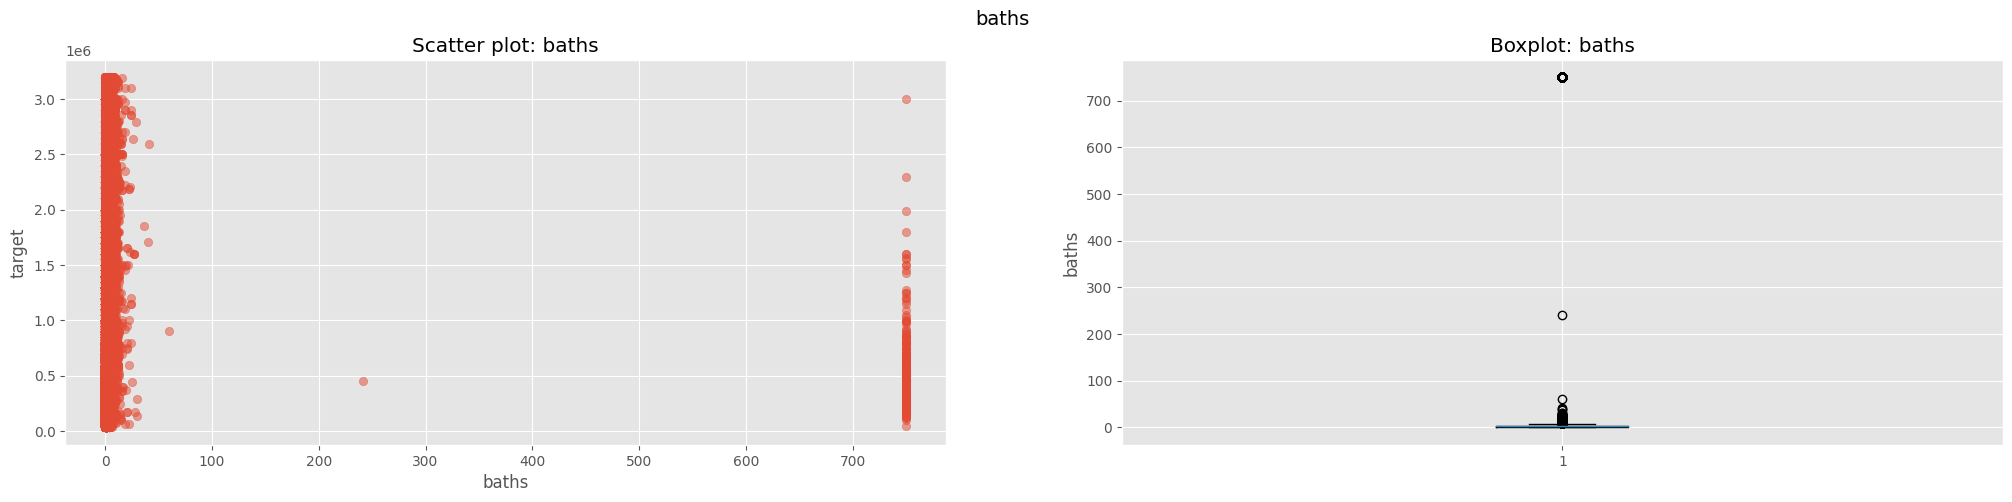

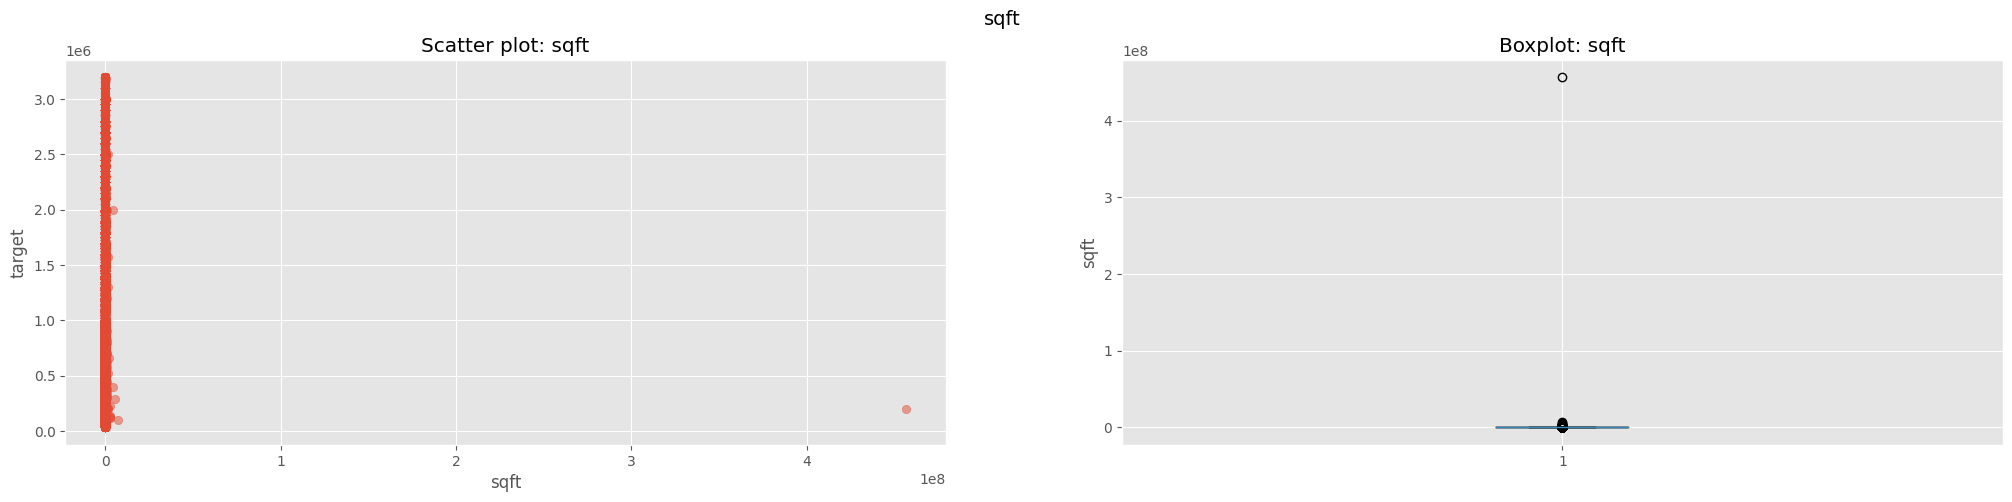

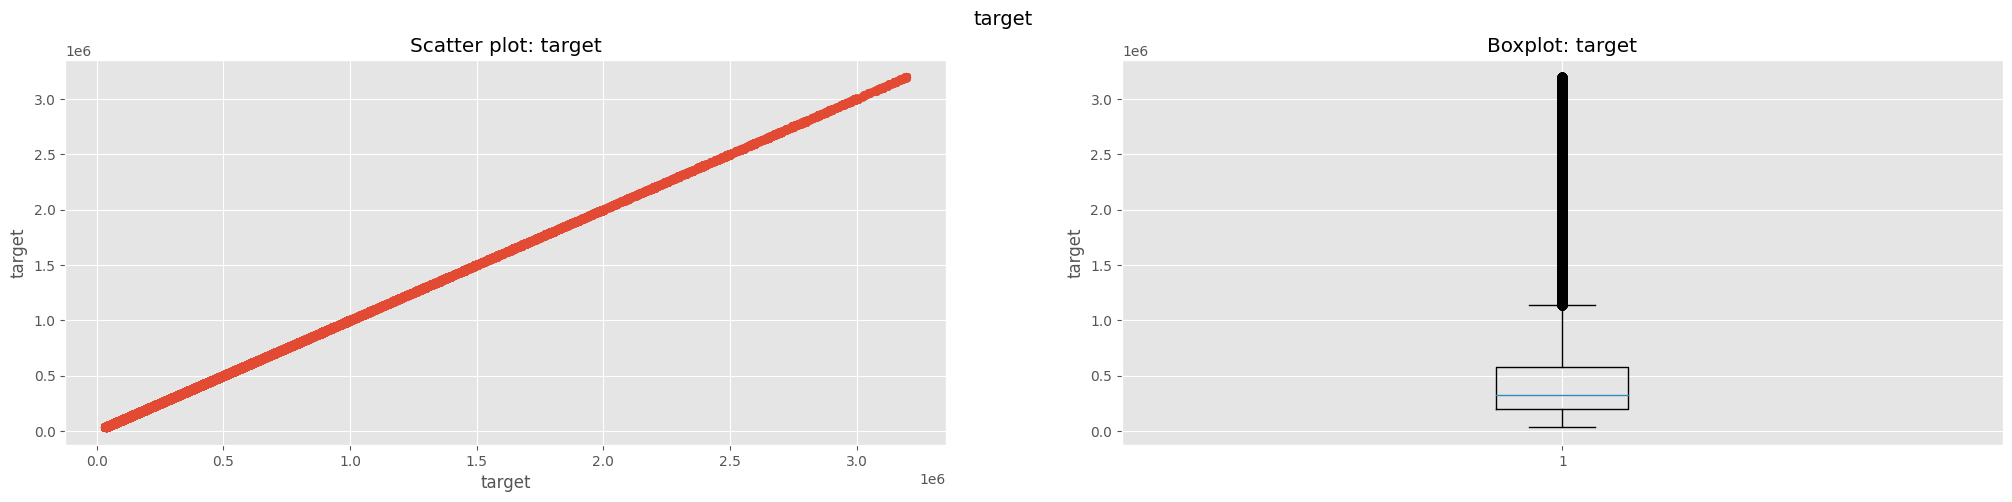

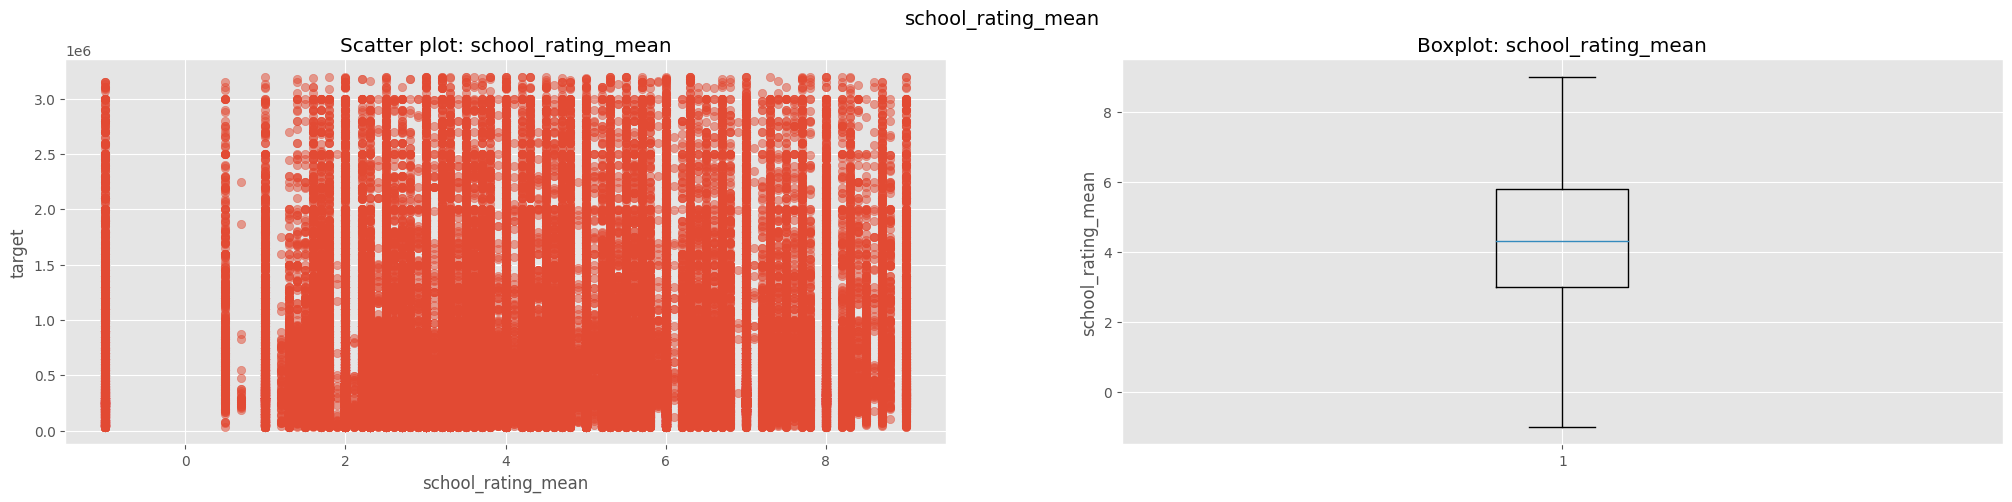

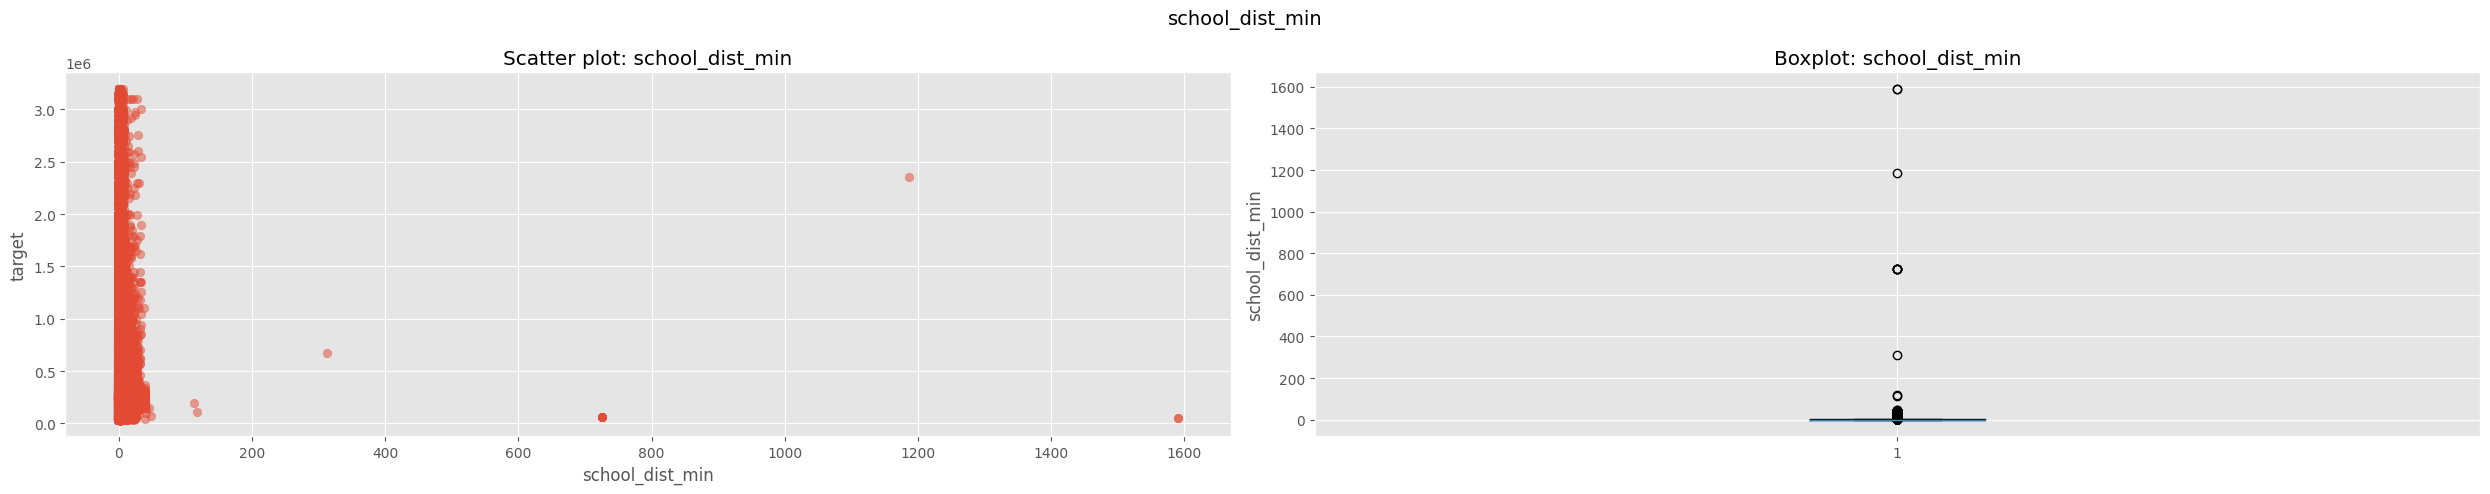

In [84]:
for feature in digital_features:
    fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
    fig.suptitle(f'{feature}', fontsize=14)
      
    barplot.scatter(df[feature], df['target'], alpha=0.5)
    barplot.set_title(f'Scatter plot: {feature}')
    barplot.set_xlabel(feature)
    barplot.set_ylabel('target')
    
    boxploot.boxplot(df[feature])
    boxploot.set_title(f'Boxplot: {feature}')
    boxploot.set_ylabel(feature)
    
plt.tight_layout()

Все признаки, кроме school_rating_mean имеют выбросы.

In [85]:
# удалим объекты, у которых более 100 ванных
df.drop(df[df['baths']>100].index, inplace=True)

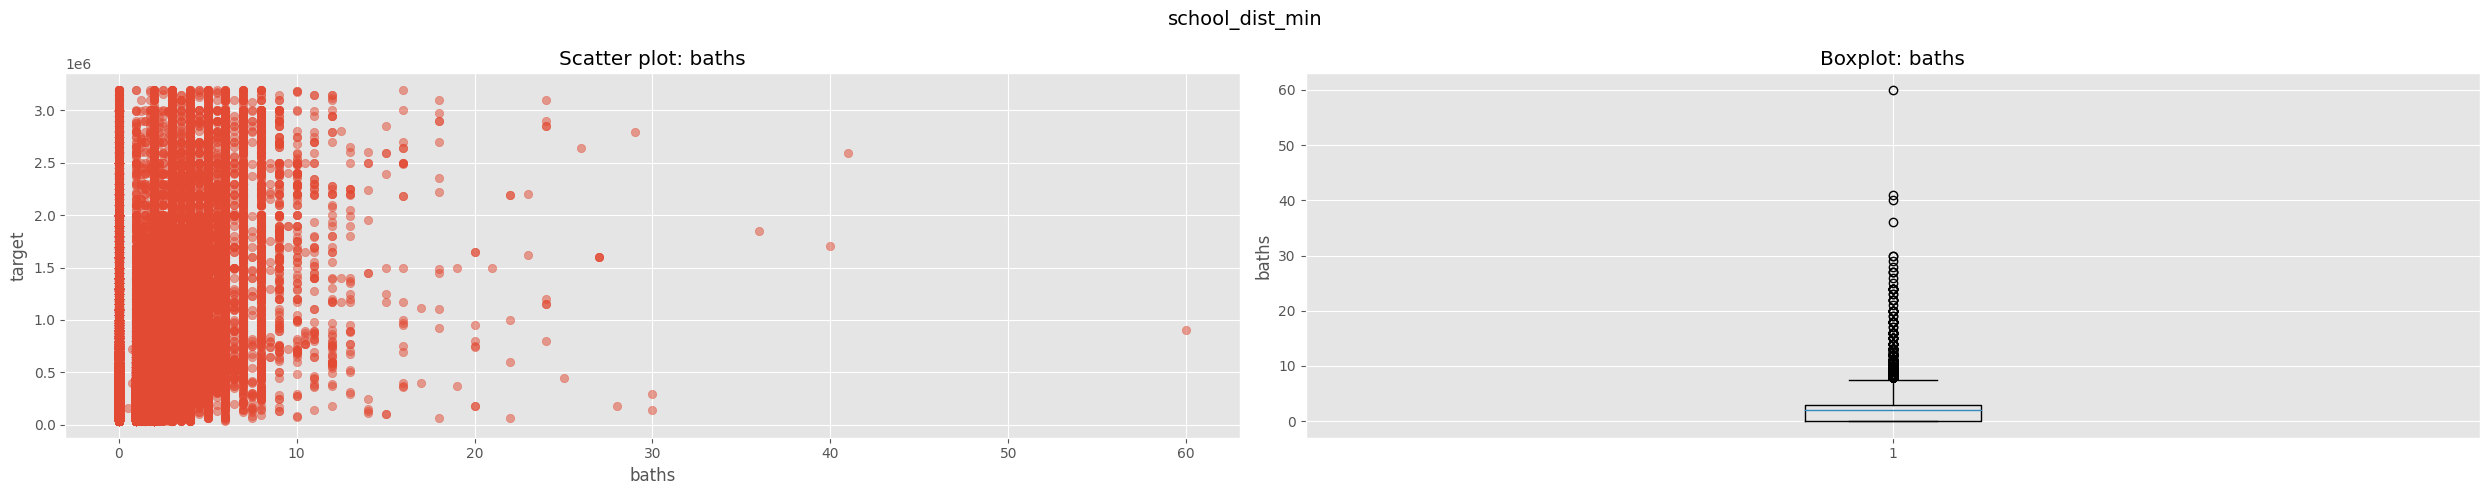

In [86]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['baths'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: baths')
barplot.set_xlabel('baths')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['baths'])
boxploot.set_title(f'Boxplot: baths')
boxploot.set_ylabel('baths')
    
plt.tight_layout()

In [87]:
# удалим объекты, у которых площадь меньше 100 и больше 30000 футов:
df.drop(df[(df['sqft'] < 100) | (df['sqft'] > 30000)].index, inplace=True)

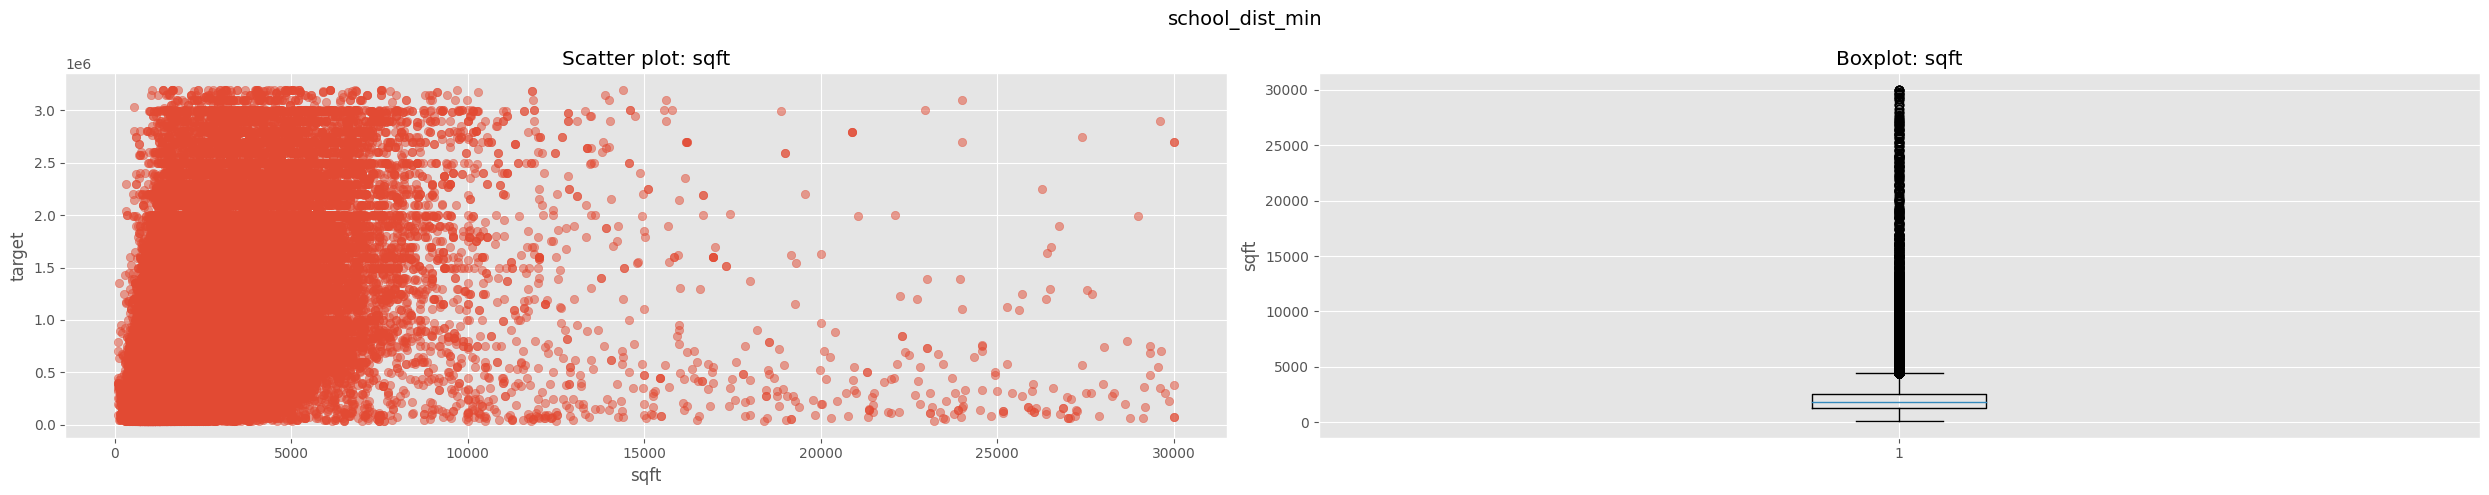

In [ ]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['sqft'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: sqft')
barplot.set_xlabel('sqft')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['sqft'])
boxploot.set_title(f'Boxplot: sqft')
boxploot.set_ylabel('sqft')
    
plt.tight_layout()

In [88]:
# удалим объекты с минимальным растоянием до школы более 30:
df.drop(df[df['school_dist_min'] > 30].index, inplace=True)

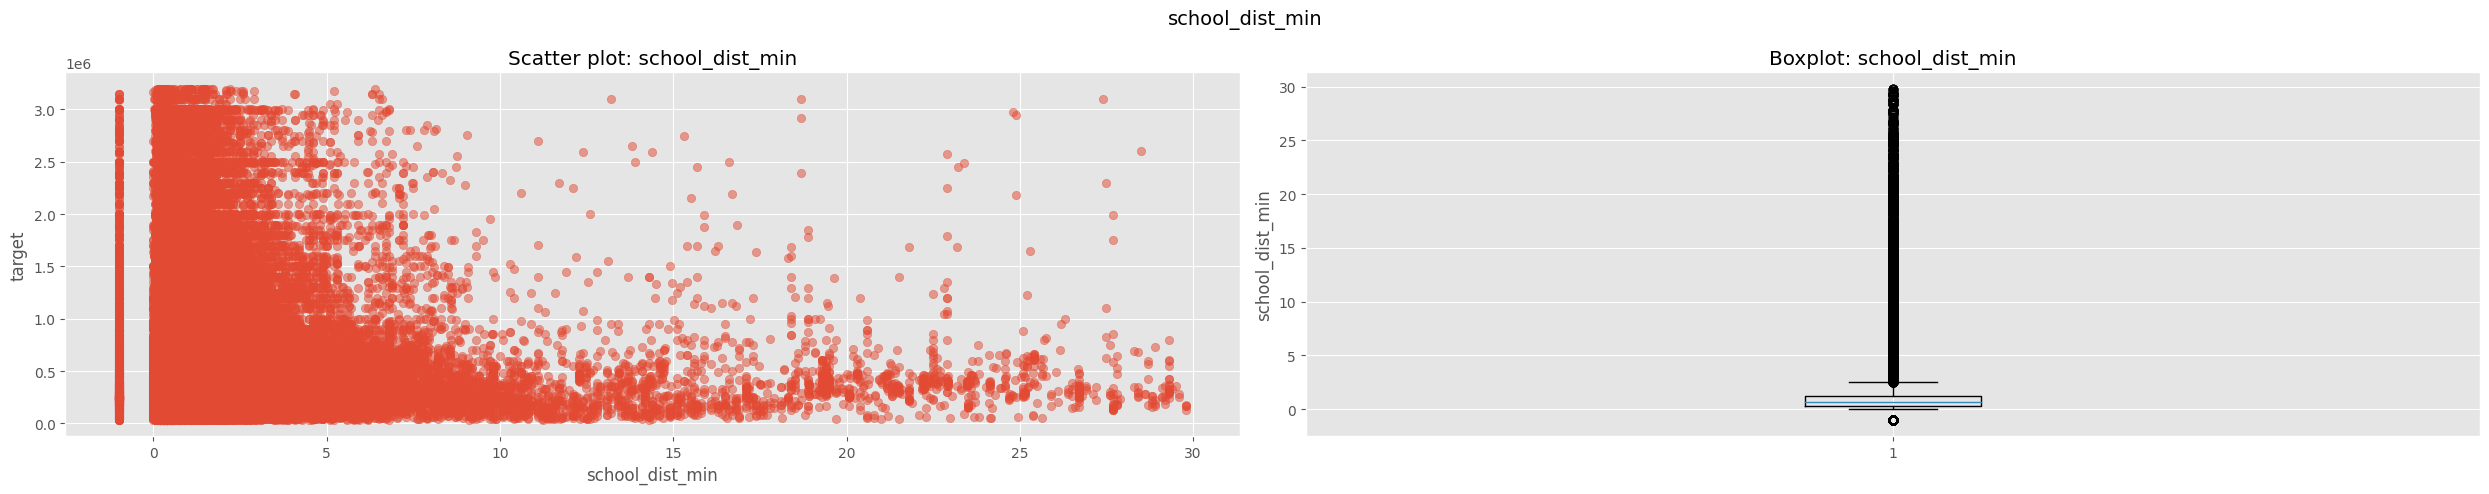

In [89]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['school_dist_min'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: school_dist_min')
barplot.set_xlabel('school_dist_min')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['school_dist_min'])
boxploot.set_title(f'Boxplot: school_dist_min')
boxploot.set_ylabel('school_dist_min')
    
plt.tight_layout()

Посмотрим на графики корреляции:

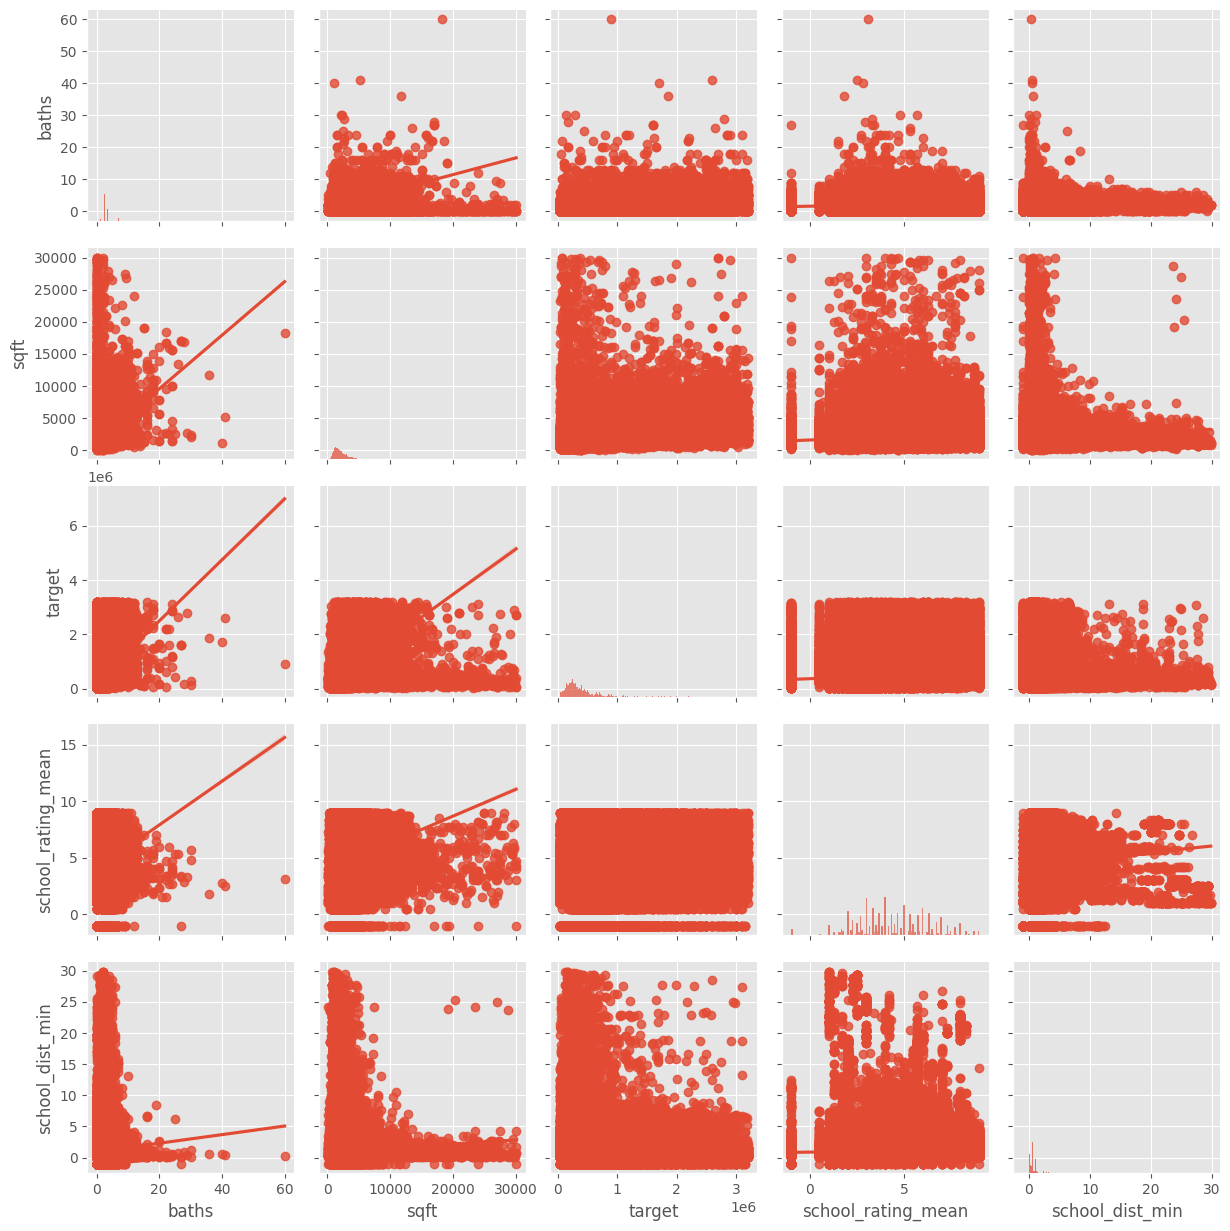

In [92]:
data_selected = df[digital_features]

sns.pairplot(data_selected, kind='reg')
#plt.savefig('data/images/plot.png', format='png')

plt.show()

Посмотрим на нормальность числовых признаков:

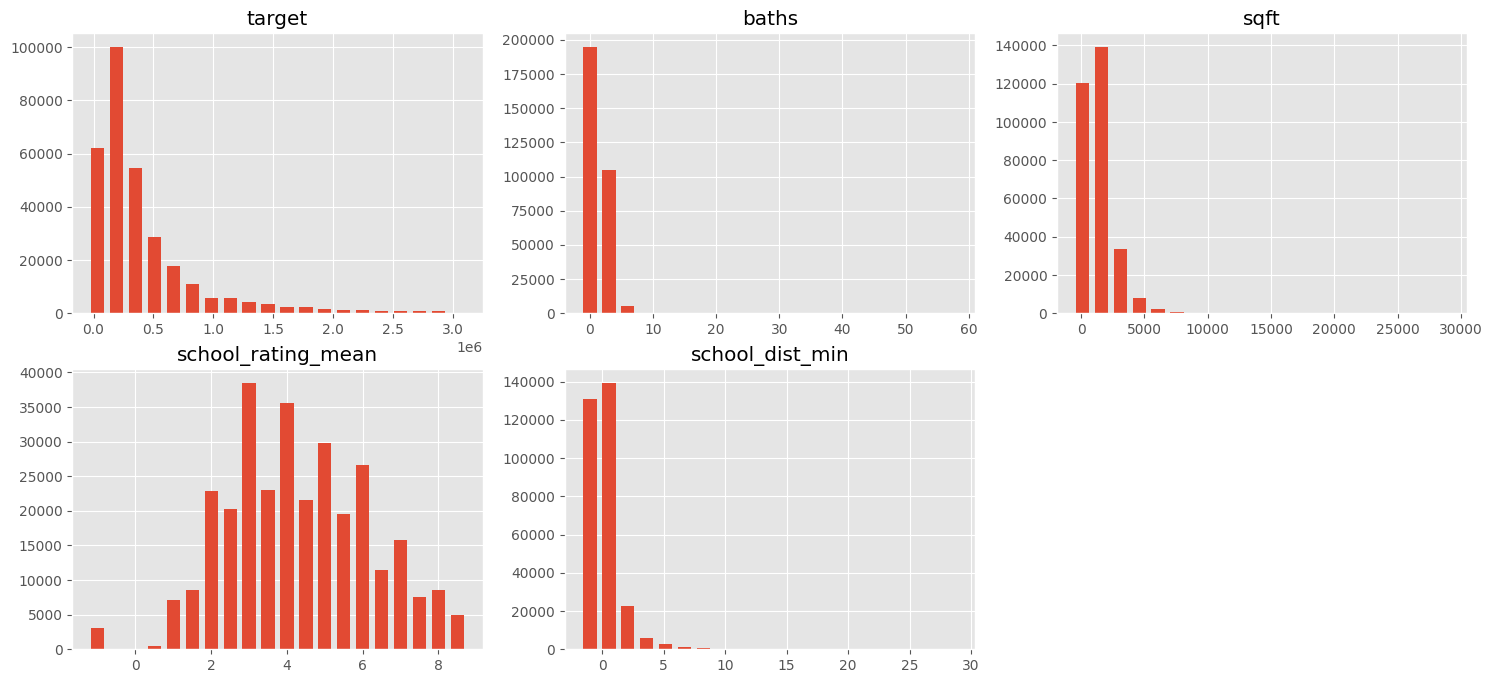

In [ ]:
def visnormaldistrib(values):
  columns = min(3, len(values))
  rows = (len(values) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(values.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()
  
visnormaldistrib({'target': df['target'], 'baths': df['baths'],'sqft': df['sqft'],'school_rating_mean': df['school_rating_mean'],'school_dist_min': df['school_dist_min']})

Нормализуем наши данные

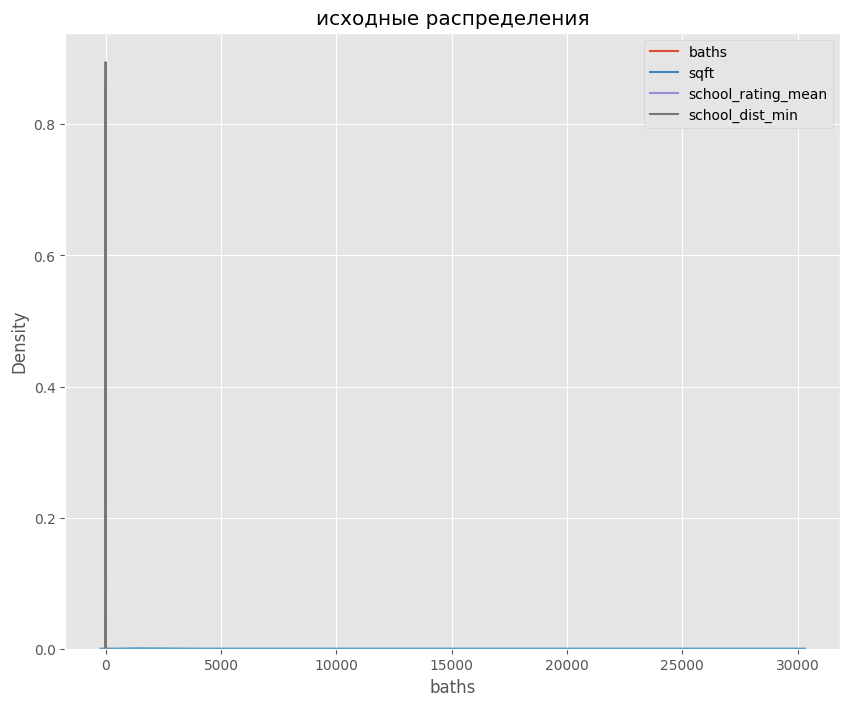

In [ ]:
filtered_df = df[digital_features]

col_names = list(filtered_df.columns)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('исходные распределения')


sns.kdeplot(filtered_df['baths'], ax=ax1, label='baths')
sns.kdeplot(filtered_df['sqft'], ax=ax1, label='sqft')
sns.kdeplot(filtered_df['school_rating_mean'], ax=ax1, label='school_rating_mean')
sns.kdeplot(filtered_df['school_dist_min'], ax=ax1, label='school_dist_min')

plt.legend()

С помощью MinMaxScaler:

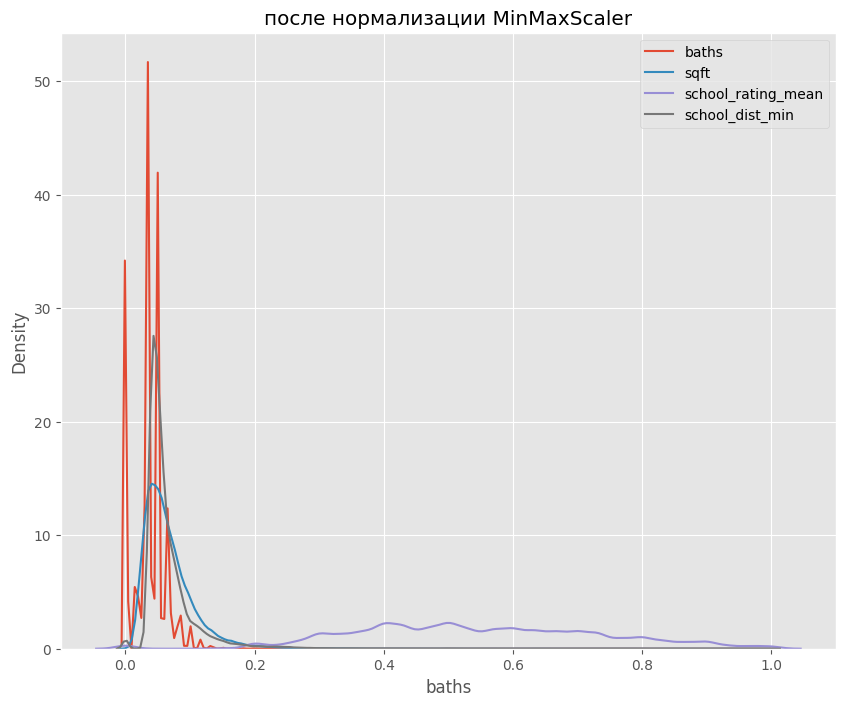

In [ ]:
filtered_df = df[digital_features]

col_names = list(filtered_df.columns)

mm_scaler = MinMaxScaler()

df_mm = mm_scaler.fit_transform(filtered_df)

df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации MinMaxScaler')


sns.kdeplot(df_mm['baths'], ax=ax1, label='baths')
sns.kdeplot(df_mm['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df_mm['school_rating_mean'], ax=ax1, label='school_rating_mean')
sns.kdeplot(df_mm['school_dist_min'], ax=ax1, label='school_dist_min')
plt.legend()

С помощью RobustScaler:

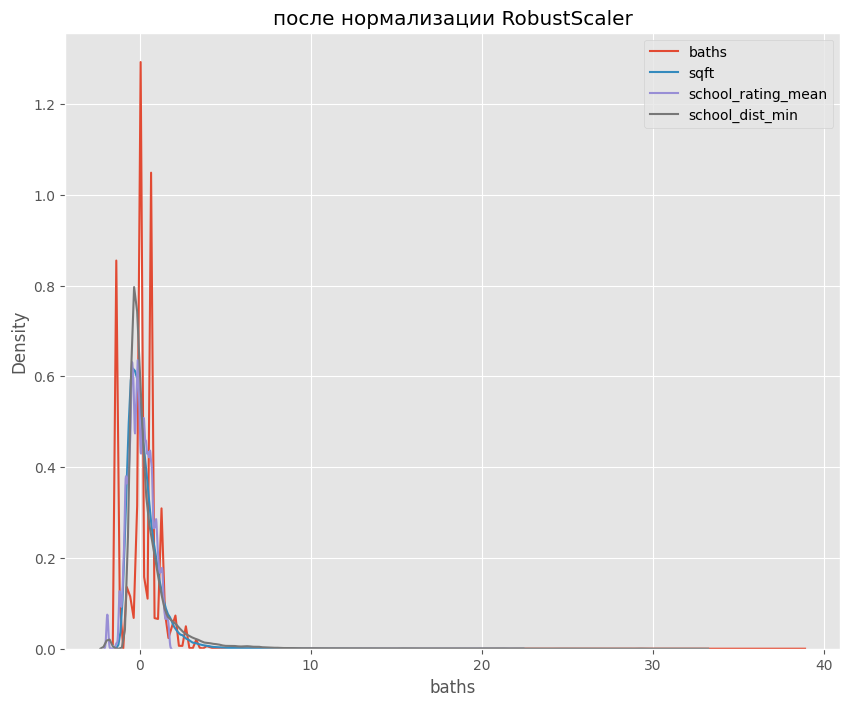

In [ ]:
r_scaler = RobustScaler()

df_r = r_scaler.fit_transform(filtered_df)

df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации RobustScaler')


sns.kdeplot(df_r['baths'], ax=ax1, label='baths')
sns.kdeplot(df_r['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df_r['school_rating_mean'], ax=ax1, label='school_rating_mean')
sns.kdeplot(df_r['school_dist_min'], ax=ax1, label='school_dist_min')
plt.legend()

Еще немного отфильтруем наши значения:

In [ ]:
sort_1 = ((df['baths'] > 30) | (df['target'] > 1000000)) | (df['school_dist_min']> 30)
sorted_1_df = df[sort_1]
sort_2 = ((df['baths'] < 1) | (df['sqft'] < 1))
sorted_2_df = df[sort_2]

print(len(sorted_1_df))
print(len(sorted_2_df))

29120
57805


In [ ]:
df.drop(df[sort_1].index, inplace=True)
df.drop(df[sort_2].index, inplace=True)

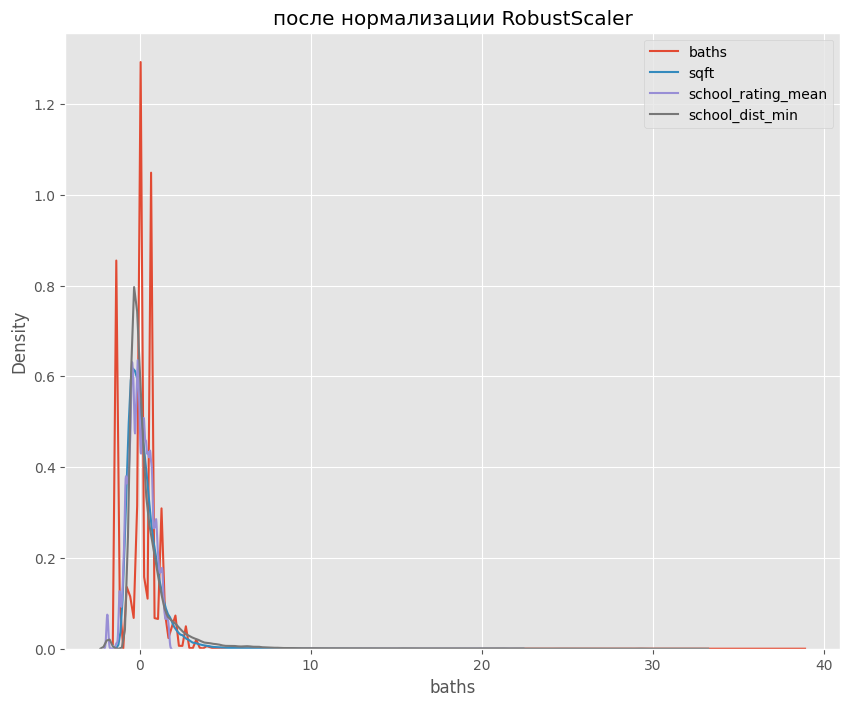

In [ ]:
col_names = list(filtered_df.columns)

r_scaler = RobustScaler()

df_r = r_scaler.fit_transform(filtered_df)

df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации RobustScaler')


sns.kdeplot(df_r['baths'], ax=ax1, label='baths')
sns.kdeplot(df_r['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df_r['school_rating_mean'], ax=ax1, label='school_rating_mean')
sns.kdeplot(df_r['school_dist_min'], ax=ax1, label='school_dist_min')
plt.legend()

Применим RobustScaler к данным:

In [ ]:
for column in digital_features:
       df[column] = r_scaler.fit_transform(df[[column]])[:,0]

#### 3.2. Анализ категориальных признаков

Посмотрим на влияние категориальных признаков на стоимость объекта, напишем функцию выводящую коробки с усами по 10 наиболее значимых значений и их влияние на стоимость объекта, пропустим через нее все категориальные признаки:

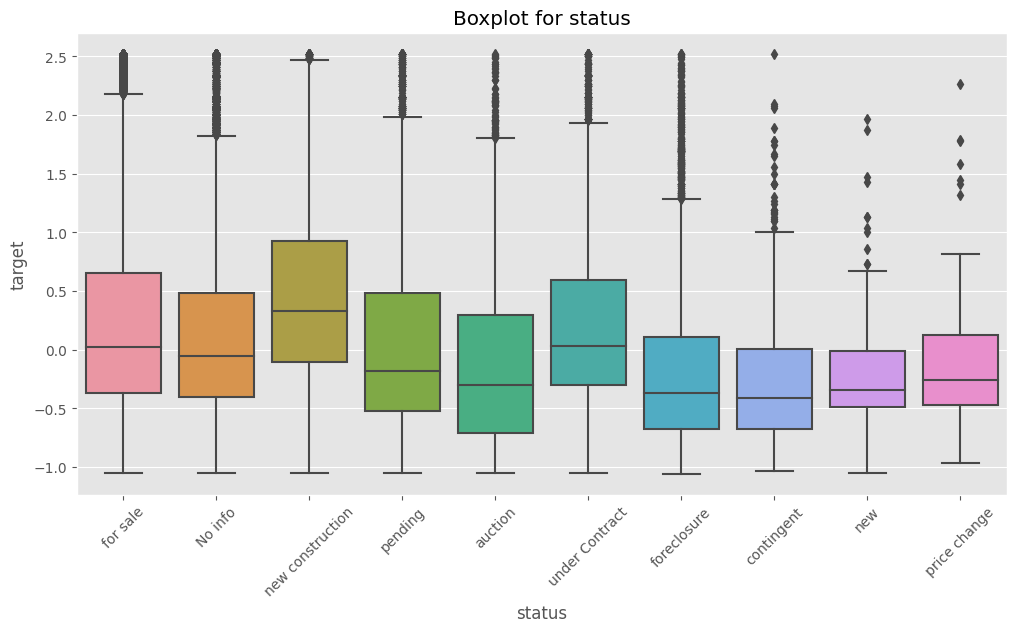

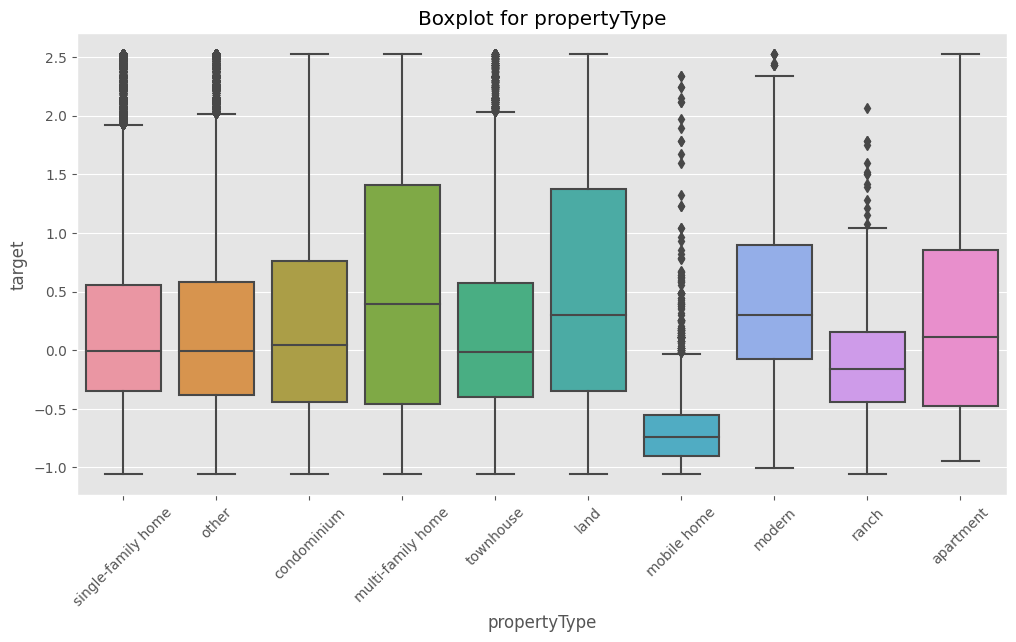

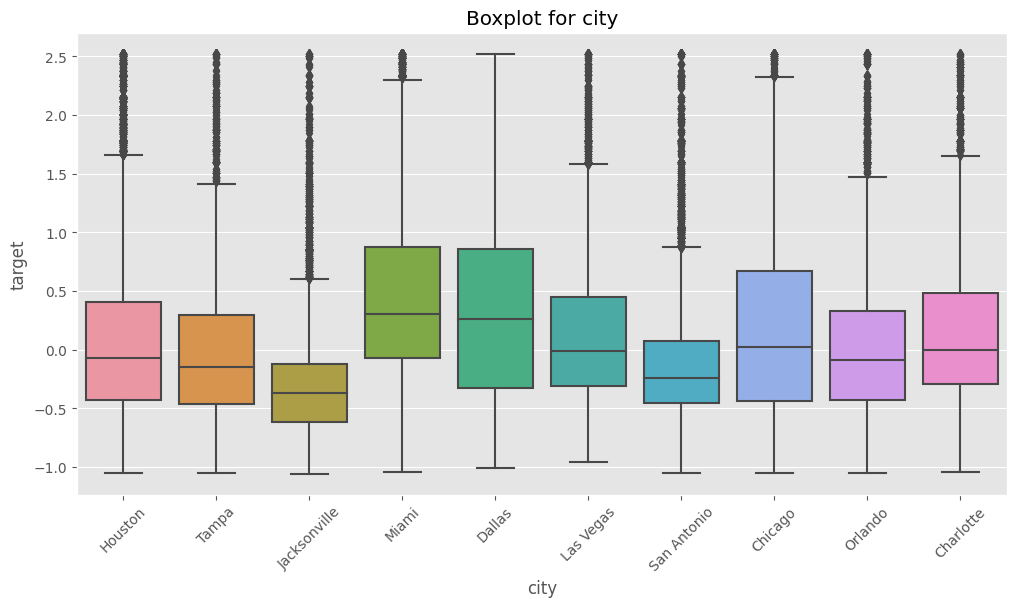

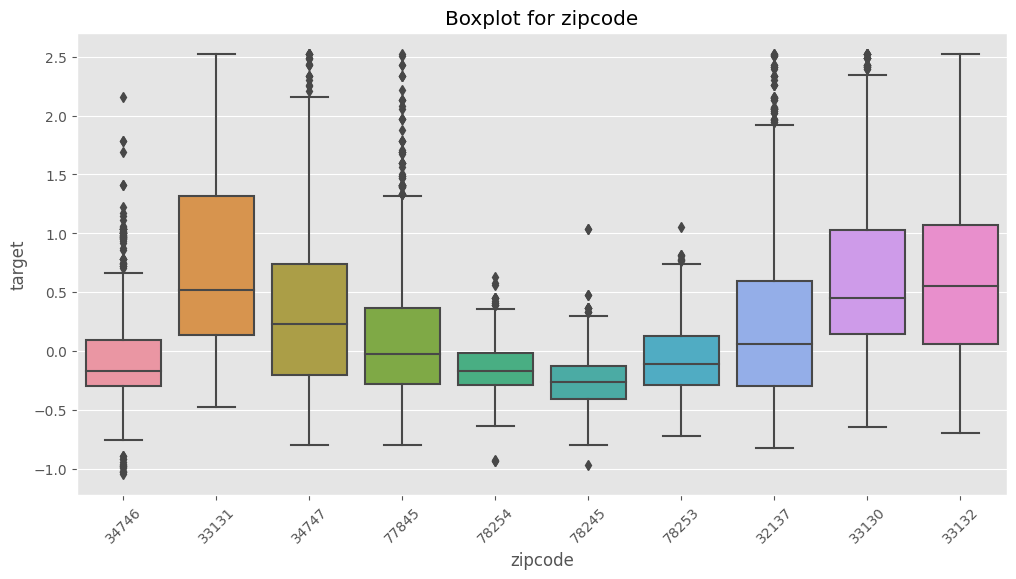

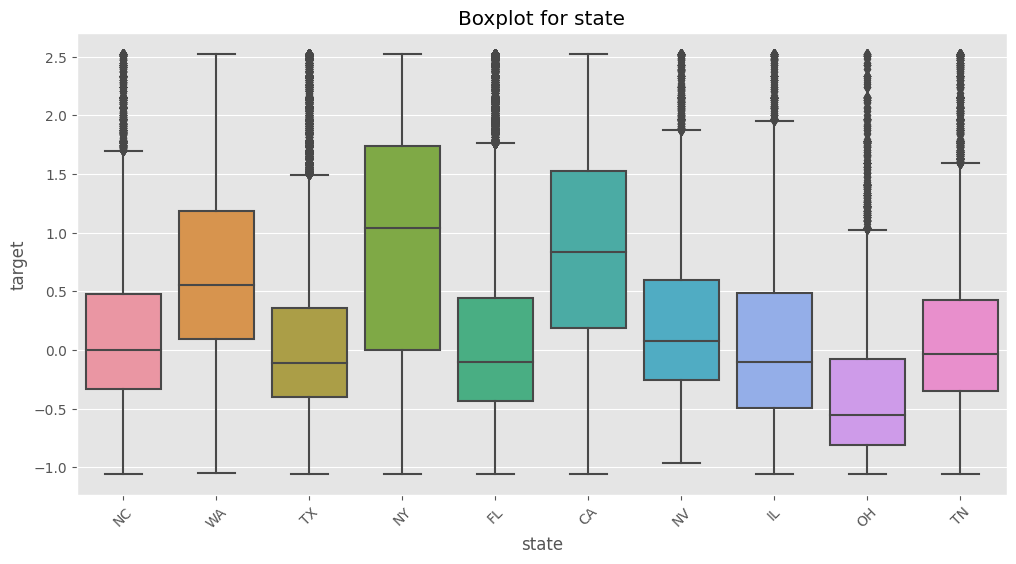

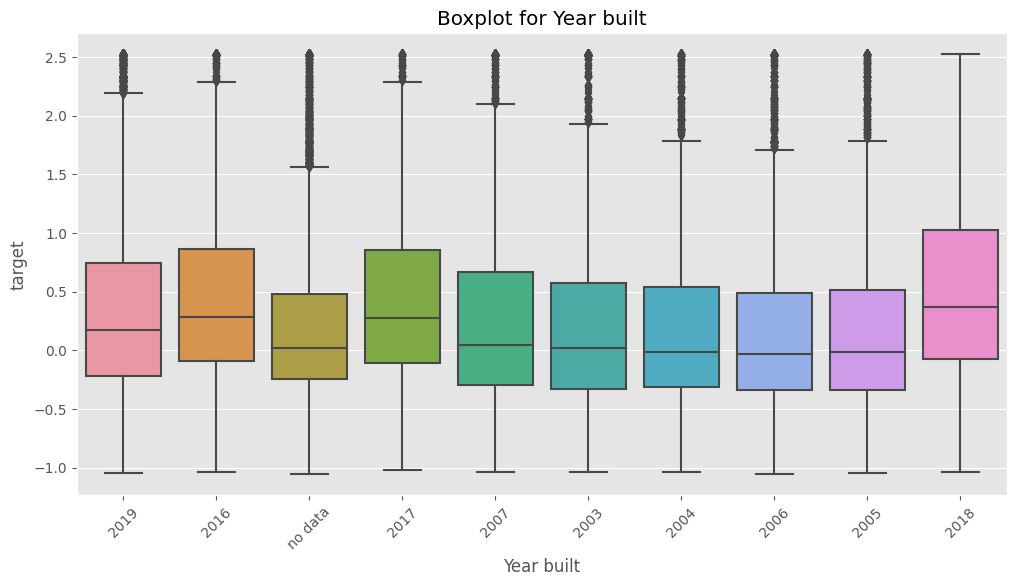

In [ ]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for col in chain(categorial_features):
    get_boxplot(col)

Построим матрицу корреляции для обнаружения линейной связи между целевым признаком и предикторами, а также признаки, которые сильно закоррелированные между собой:

<AxesSubplot: >

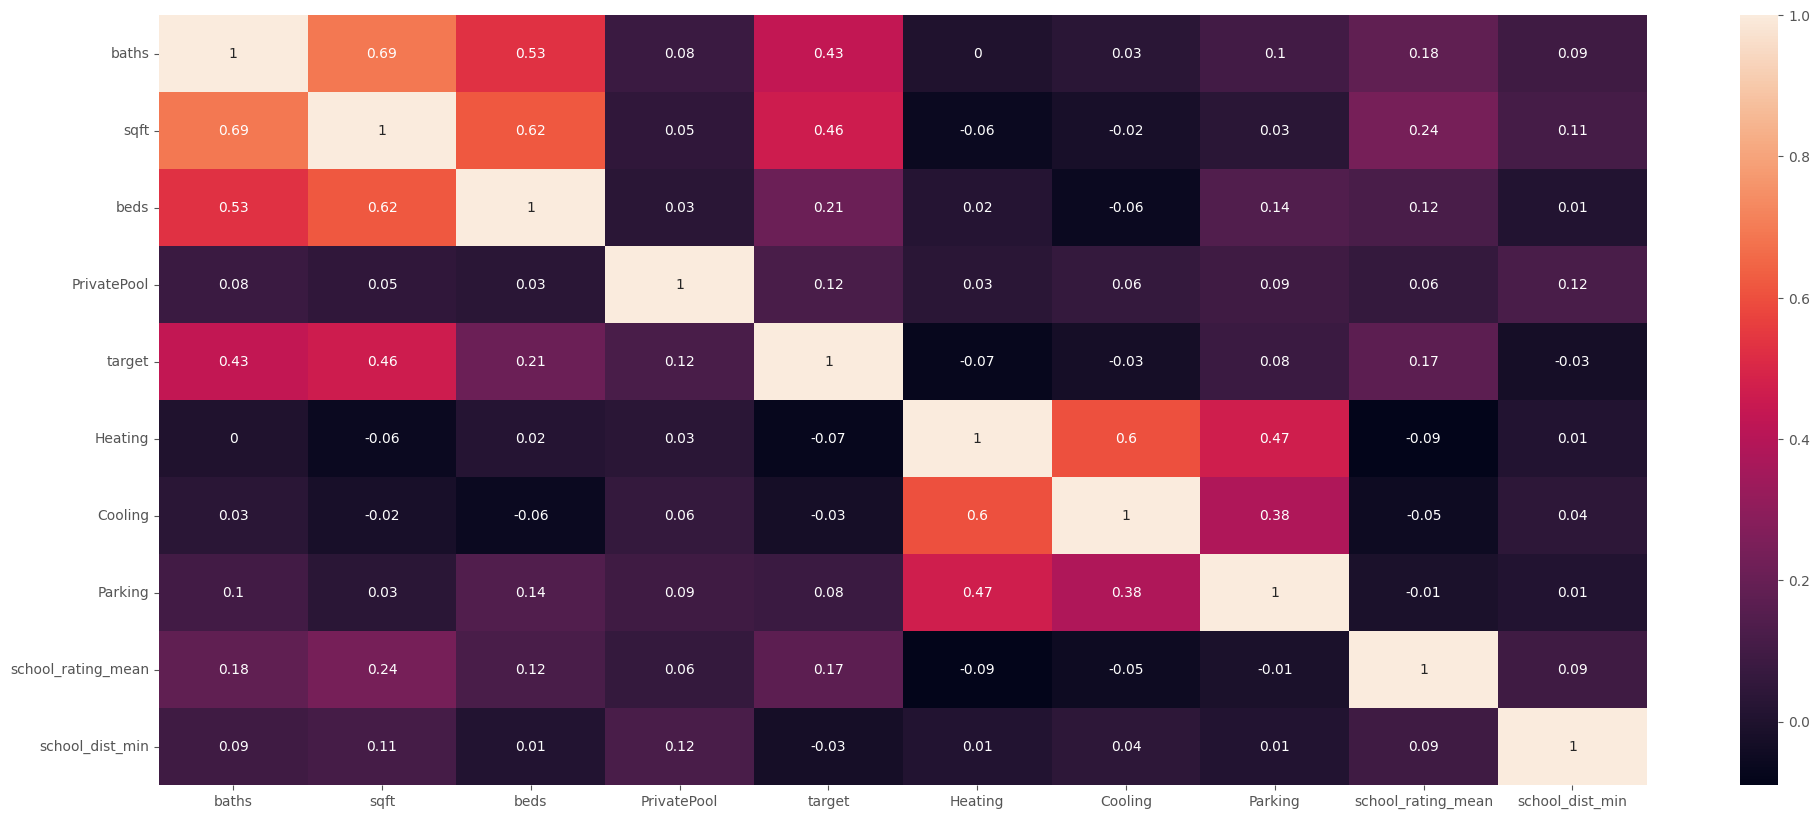

In [ ]:
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(df.corr(method='spearman'), 2), annot=True)

Мультиколлинеарность отсутствует. Можно переходить к кодированию признаков.

### 4. Кодирование признаков

In [ ]:
# сохраним нормализованный датасет 
df.to_csv('data_normalized.csv', index=False)
df_norm = pd.read_csv('data/data_normalized.csv')

In [ ]:
bin_encoder = ce.BinaryEncoder(df_norm['propertyType'])
propertyType_bin = bin_encoder.fit_transform(df_norm['propertyType'])
df_norm = pd.concat([df_norm,propertyType_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_norm['status'])
status_bin = bin_encoder.fit_transform(df_norm['status'])
df_norm = pd.concat([df_norm,status_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_norm['state'])
state_bin = bin_encoder.fit_transform(df_norm['state'])
df_norm = pd.concat([df_norm,state_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_norm['city'])
city_bin = bin_encoder.fit_transform(df_norm['city'])
df_norm = pd.concat([df_norm,city_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_norm['zipcode'])
zipcode_bin = bin_encoder.fit_transform(df_norm['zipcode'])
df_norm = pd.concat([df_norm,zipcode_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_norm['Year built'])
Yearbuilt_bin = bin_encoder.fit_transform(df_norm['Year built'])
df_norm = pd.concat([df_norm,Yearbuilt_bin], axis=1)


df_norm.drop(['propertyType', 'status', 'state', 'city', 'zipcode', 'Year built'],axis=1,inplace=True)

In [ ]:
df_norm.head()

,baths,sqft,beds,PrivatePool,target,Heating,Cooling,Parking,school_rating_mean,school_dist_min,...,zipcode_10,zipcode_11,Year built_0,Year built_1,Year built_2,Year built_3,Year built_4,Year built_5,Year built_6,Year built_7
0,1.5,0.966846,4.0,0,0.366949,1,0,0,0.321429,2.195652,...,0,1,0,0,0,0,0,0,0,1
1,1.0,0.112903,3.0,0,-0.033359,0,0,0,-0.107143,0.358696,...,1,0,0,0,0,0,0,0,0,1
2,0.0,1.583333,3.0,0,-0.274656,1,1,0,-0.178571,5.347826,...,1,1,0,0,0,0,0,0,1,0
3,1.0,0.097670,3.0,0,-0.025964,1,1,1,-0.464286,-0.086957,...,0,0,0,0,0,0,0,0,0,1
4,0.0,-0.466846,3.0,0,1.297296,0,0,1,-0.535714,-0.413043,...,0,1,0,0,0,0,0,0,1,1


### 5. Моделирование

Начнем с построения базовой модели результаты которой будем улучшать последующими моделями. Определимся с метриками и разделим выборку на тренировочную и тестовую в соотношении 80/20. Здесь и далее будем обеспечивать воспроизводимость параметром random_state = 42.

За базовую модель возьмем модель линейной регрессии с параметрами по умолчанию.

In [ ]:
X = df_norm.drop(['target'], axis=1)
y = df_norm['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [ ]:
# создадим функцию, принимающую выборки, предсказания и название модели, а возвращающую словарь со значениями метрик
def metrics_func(y_train,y_test,y_train_pred,y_test_pred, model_name):
    metric_dict = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R^2', 'Test R^2']}
    mse_train = metrics.mean_squared_error(y_train, y_train_pred)
    mse_test = metrics.mean_squared_error(y_test, y_test_pred)
    mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
    mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
    r2_train = metrics.r2_score(y_train, y_train_pred)
    r2_test = metrics.r2_score(y_test, y_test_pred)
    
    metric_dict[model_name] = [round(mse_train,2), round(mse_test,2), round(mae_train,2), round(mae_test,2), round(r2_train,2), round(r2_test,2)]
           
    return metric_dict

In [ ]:
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)

# вычисляем коэффициенты регрессии
model.fit(X_train, y_train)

# делаем предсказания с помощью модели
base_y_train_pred = model.predict(X_train)
base_y_test_pred = model.predict(X_test)

Посмотрим на значение метрик применительно к базовой модели(линейная ригрессия с параметрами по умолчанию):

In [ ]:
lr_dict = metrics_func(y_train, y_test, base_y_train_pred, base_y_test_pred, 'Baseline(LR)')
display(pd.DataFrame(lr_dict))

,Metric,Baseline(LR)
0,Train MSE,0.46
1,Test MSE,0.45
2,Train MAE,0.51
3,Test MAE,0.51
4,Train R^2,0.28
5,Test R^2,0.28


MSE = 0.45 и MAE = 0.51 - указывают на то, что модель неплохо справляется с предсказанием, влияние оставшихся выбросов на ошибку не велико. Значения как для тестовой так и для обучающей выборки одинаковые, что говорит об отсутвие переобучения. Однако, R^2 = 0.28 говорит о том, что модель только в 28% случаев объясняет изменение целевой переменной.

Посмотрим как изменится результат модели, если построить ее только на признаках, оказывающих наибольшее влияние на результат. Для этого будем использовать метод SelectKBest. Метод SelectKBest осуществляет одномерный выбор признаков с наивысшей оценкой, работает путем выбора лучших признаков на основе одномерных статистических тестов.

In [ ]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(X_train, y_train)
best_features = selector.get_feature_names_out()
best_features

array(['baths', 'sqft', 'beds', 'PrivatePool', 'Heating', 'Cooling',
       'Parking', 'school_rating_mean', 'status_1', 'status_2',
       'status_3', 'status_4', 'state_2', 'state_3', 'state_4', 'city_4',
       'city_5', 'city_6', 'city_8', 'city_9', 'zipcode_2', 'zipcode_5',
       'zipcode_11', 'Year built_3', 'Year built_4'], dtype=object)

Построим модель линейной регрессии используя только те признаки, которые выбрны методом SelectKBest:

In [ ]:
lr_bf = LinearRegression()
lr_bf.fit(X_train[best_features], y_train)
y_train_predict = lr_bf.predict(X_train[best_features])
y_test_predict = lr_bf.predict(X_test[best_features])

lr_bf_dict = metrics_func(y_train, y_test, y_train_predict, y_test_predict, 'Best features(LR)')
display(pd.DataFrame(lr_bf_dict))

,Metric,Best features(LR)
0,Train MSE,0.47
1,Test MSE,0.46
2,Train MAE,0.52
3,Test MAE,0.52
4,Train R^2,0.26
5,Test R^2,0.27


Метод SelectKBest не помог нам улучшить модель.

Попробуем построить модель на полиномиальных признаках. Для этого используем метод PolynomialFeatures:

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=True)

poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

model_lin_poly = LinearRegression()
model_lin_poly.fit(X_train_poly, y_train)
poly_y_train_pred = model_lin_poly.predict(X_train_poly)
poly_y_test_pred = model_lin_poly.predict(X_test_poly)

In [ ]:
lr_poly_dict = metrics_func(y_train, y_test, poly_y_train_pred, poly_y_test_pred, 'PolynomialFeatures(LR)')
display(pd.DataFrame(lr_poly_dict))

,Metric,PolynomialFeatures(LR)
0,Train MSE,2.400000e-01
1,Test MSE,3.936289e+09
2,Train MAE,3.600000e-01
3,Test MAE,4.609100e+02
4,Train R^2,6.200000e-01
5,Test R^2,-6.242485e+09


Видно, что модель потеряла способность к предсказанию, что вполне предсказуемо в свете выбранного нами способа кодирования признаков. Мы кодировали признаки двумя методами: LabelEncoder и BinaryEncoder. Метод PolynomialFeatures создает новые признаки возведением в степень имеющихся, возвидение в степень бинарных признаков привело к появлению ничего не значащих признаков в большом числовом выражении.

#### ElasticNetCV и GridSearchCV

Попробуем улучшить предсказательную способность регрессии используя ElasticNetCV и GridSearchCV.

In [ ]:
model_el = ElasticNetCV(cv=5, random_state=42)

parametrs = { 'l1_ratio': np.arange (0.01,1., 0.01)}

grid = GridSearchCV(estimator=model_el,param_grid=parametrs, cv=5,scoring='r2', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

best_params = grid.best_params_

model_el_best = ElasticNetCV(l1_ratio=best_params['l1_ratio'], cv=5, random_state=42)

model_el_best.fit(X_train, y_train)


encv_y_train_pred = model_el_best.predict(X_train)
encv_y_test_pred = model_el_best.predict(X_test)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


In [ ]:
encv_dict = metrics_func(y_train, y_test, encv_y_train_pred, encv_y_test_pred, 'ElasticNetCV(optimal)')
display(pd.DataFrame(encv_dict))
print(best_params)

,Metric,ElasticNetCV(optimal)
0,Train MSE,0.46
1,Test MSE,0.45
2,Train MAE,0.51
3,Test MAE,0.51
4,Train R^2,0.28
5,Test R^2,0.28


{'l1_ratio': 0.99}


Результат ElasticNetCV оказался идентичен LinearRegression, что предсказуемо с учетом предшествовавшему удалению выбросов.

#### DecisionTreeRegressor

Проверим как модель дерева решений справится с нашей задачей.

In [ ]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

dt_regressor_y_train_pred = dt_regressor.predict(X_train)
dt_regressor_y_test_pred = dt_regressor.predict(X_test)

In [ ]:
dt_regressor_dict = metrics_func(y_train, y_test, dt_regressor_y_train_pred, dt_regressor_y_test_pred, 'DecisionTreeRegressor')
display(pd.DataFrame(dt_regressor_dict))

,Metric,DecisionTreeRegressor
0,Train MSE,0.00
1,Test MSE,0.31
2,Train MAE,0.00
3,Test MAE,0.34
4,Train R^2,1.00
5,Test R^2,0.51


Переобучение на лицо. Подберем оптимальную глубину дерева решений основываясь на разнице значения метрики R^2

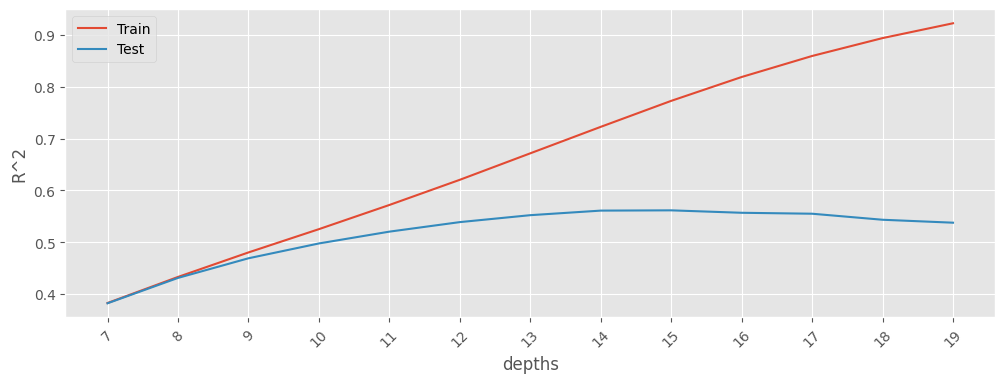

In [ ]:
max_depths = range(7, 20)

train_scores = []
test_scores = []
for depth in max_depths:
    
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    dt_regressor.fit(X_train, y_train)
    
    dt_regressor_y_train_predict = dt_regressor.predict(X_train)
    dt_regressor_y_test_predict = dt_regressor.predict(X_test)
    
    train_scores.append(metrics.r2_score(y_train, dt_regressor_y_train_predict))
    test_scores.append(metrics.r2_score(y_test, dt_regressor_y_test_predict))
    
    

fig, ax = plt.subplots(figsize=(12, 4)) 
ax.plot(max_depths, train_scores, label='Train') 
ax.plot(max_depths, test_scores, label='Test') 
ax.set_xlabel('depths') 
ax.set_ylabel('R^2') 
ax.set_xticks(max_depths) 
ax.xaxis.set_tick_params(rotation=45) 
ax.legend(); 

На графике видно как расходятся значения метрики на тестовой и обучающей выборке в зависимости от изменения глубины деревьем. Для опримизмции результата выберем глубину 13:

In [ ]:
dt_regressor_opt = DecisionTreeRegressor(max_depth=13 , random_state=42)
dt_regressor_opt.fit(X_train, y_train)

dt_regressor_opt_y_train_pred = dt_regressor_opt.predict(X_train)
dt_regressor_opt_y_test_pred = dt_regressor_opt.predict(X_test)

In [ ]:
dt_regressor_opt_dict = metrics_func(y_train, y_test, dt_regressor_opt_y_train_pred, dt_regressor_opt_y_test_pred, 'DecisionTreeRegressor(optimal)')
display(pd.DataFrame(dt_regressor_opt_dict))

,Metric,DecisionTreeRegressor(optimal)
0,Train MSE,0.21
1,Test MSE,0.28
2,Train MAE,0.32
3,Test MAE,0.37
4,Train R^2,0.67
5,Test R^2,0.55


Удалось снизить переобучене модели, но она все еще остается высокой.

#### RandomForestRegression

Попробуем модель бэггинга RandomForestRegressor. Случайный лес использует усреднение для повышения точности прогнозирования и контроля переобучения. Посмотрим как с решением нашей задачи справится случайный лес.

In [ ]:
rf_regressor = RandomForestRegressor(random_state=42)

rf_regressor.fit(X_train, y_train)

rfr_y_train_pred = rf_regressor.predict(X_train)
rfr_y_test_pred = rf_regressor.predict(X_test)

In [ ]:
rf_dict = metrics_func(y_train, y_test, rfr_y_train_pred, rfr_y_test_pred, 'RandomForestRegressor')
display(pd.DataFrame(rf_dict))

,Metric,RandomForestRegressor
0,Train MSE,0.02
1,Test MSE,0.14
2,Train MAE,0.09
3,Test MAE,0.25
4,Train R^2,0.97
5,Test R^2,0.78


Видим что модель RandomForestRegressor справилась лучше чем предыдущие модели. Предсказания точнее, определение зависимости моделью выросло более чем в два раза. При этом все еще наблюдается переобучение. Попробуем еще улучшить нашу модель:

In [ ]:
parametrs = { 'n_estimators': [200, 300],
              'max_depth': [ 7, 13],
              'min_samples_leaf': [1, 4],
              'min_samples_split': [2, 5]}

grid = GridSearchCV(estimator=rf_regressor, param_grid=parametrs, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

rf_best_params = grid.best_params_

srf_best_regressor = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'], 
                                           max_depth = rf_best_params['max_depth'], min_samples_leaf = rf_best_params['min_samples_leaf'], 
                                           min_samples_split =  rf_best_params['min_samples_split'], random_state=42)

srf_best_regressor.fit(X_train, y_train)
srf_best_y_train_pred = srf_best_regressor.predict(X_train)
srf_best_y_test_pred = srf_best_regressor.predict(X_test)

grid.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': 13,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
srf_best_dict = metrics_func(y_train, y_test, srf_best_y_train_pred, srf_best_y_test_pred, 'RandomForestRegressor(best)')
display(pd.DataFrame(srf_best_dict))
print(rf_best_params)

,Metric,RandomForestRegressor(best)
0,Train MSE,0.17
1,Test MSE,0.21
2,Train MAE,0.29
3,Test MAE,0.33
4,Train R^2,0.74
5,Test R^2,0.66


{'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Удалось снизить степень переобучения модели, однако предсказательная способность модели тоже снизилась.

#### GradientBoostingRegressor

GradientBoostingRegressor строит модель поэтапно, что позволяет оптимизировать произвольные дифференцируемые функции потерь. Посмотрим какие показатели даст модель:

In [ ]:
gb = GradientBoostingRegressor(
    max_depth=9, 
    n_estimators=500, 
    random_state=42, 
    learning_rate=0.01
)

gb.fit(X_train, y_train)

gb_y_train_pred  = gb.predict(X_train)
gb_y_test_pred = gb.predict(X_test)

In [ ]:
gb_dict = metrics_func(y_train, y_test, gb_y_train_pred, gb_y_test_pred, 'GradientBoostingRegressor')
display(pd.DataFrame(gb_dict))

,Metric,GradientBoostingRegressor
0,Train MSE,0.18
1,Test MSE,0.20
2,Train MAE,0.31
3,Test MAE,0.32
4,Train R^2,0.72
5,Test R^2,0.68


GradientBoostingRegressor выдает значения метрик, близкие к результатам оптимизированной RandomForestRegressor, при этом немного лучше избегает переобучения.

#### CatBoostRegression

Посмотрим на модель бустинга CatBoostRegressor. CatBoostRegressor может работать с категориальными признаками без их кодирования, поэтому создадим новое разбиение выборки, на основе данных до кодирования:

In [ ]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [ ]:
cb_model = CatBoostRegressor(random_seed=42, silent=True)

param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],}

grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train, cat_features=categorial_features)
cb_best_params = grid_search.best_params_

best_cb_model = CatBoostRegressor(iterations=cb_best_params['iterations'], learning_rate=cb_best_params['learning_rate'], 
                                  depth=cb_best_params['depth'], l2_leaf_reg=cb_best_params['l2_leaf_reg'], random_seed=42, silent=True)

best_cb_model.fit(X_train, y_train, cat_features=categorial_features)

cb_y_train_pred = best_cb_model.predict(X_train)
cb_y_test_pred = best_cb_model.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
cb_dict = metrics_func(y_train, y_test, cb_y_train_pred, cb_y_test_pred, 'CatBoostRegressor(Optimal)')
display(pd.DataFrame(cb_dict))
print(cb_best_params)

,Metric,CatBoostRegressor(Optimal)
0,Train MSE,0.10
1,Test MSE,0.11
2,Train MAE,0.22
3,Test MAE,0.23
4,Train R^2,0.84
5,Test R^2,0.82


{'depth': 8, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


#### Сравнение результатов моделей

In [ ]:
compare = lr_dict |lr_bf_dict | dt_regressor_dict | dt_regressor_opt_dict | encv_dict | rf_dict | srf_best_dict | gb_dict | cb_dict
display(pd.DataFrame(compare))

,Metric,Baseline(LR),Best features(LR),DecisionTreeRegressor,DecisionTreeRegressor(optimal),ElasticNetCV(optimal),RandomForestRegressor,RandomForestRegressor(best),GradientBoostingRegressor,CatBoostRegressor(Optimal)
0,Train MSE,0.46,0.47,0.00,0.21,0.46,0.02,0.17,0.18,0.10
1,Test MSE,0.45,0.46,0.31,0.28,0.45,0.14,0.21,0.20,0.11
2,Train MAE,0.51,0.52,0.00,0.32,0.51,0.09,0.29,0.31,0.22
3,Test MAE,0.51,0.52,0.34,0.37,0.51,0.25,0.33,0.32,0.23
4,Train R^2,0.28,0.26,1.00,0.67,0.28,0.97,0.74,0.72,0.84
5,Test R^2,0.28,0.27,0.51,0.55,0.28,0.78,0.66,0.68,0.82


Нами было построенно 9 моделей, демонстрирующих разные показатели эффективности работы. Наилучшие показатели наблюдаются у ансамблиевых методов: RandomForestRegressor(best), GradientBoostingRegressor, CatBoostRegressor(Optimal). Наилучшие показатели у CatBoostRegressor(Optimal), модель хорошо "чувствует" закономерности, демонстрирует наименьшие показатели ошибки с учетом соотнесения результатов на тестовой и тренировочной выборках.

CatBoostRegressor(Optimal) будем использовать в продакте.